In [1]:
# Standard libraries
import os
from glob import glob
import itertools
import pickle

# Basic 3rd party libraries
import pandas as pd
import numpy as np

# Plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter

# scikit processing
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report

# scikit models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier

# TensorFlow Keras API
from tensorflow.keras.utils import (
    plot_model as tf_plot,
    to_categorical,
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import CategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy, BinaryAccuracy

# TensorFlow Keras model and layers API
from tensorflow.keras.layers import (
    Input,
    Reshape,
    Flatten,
    Conv1D,
    Conv2D,
    MaxPooling1D,
    MaxPooling2D,
    Dense,
    Dropout,
    Concatenate,
)
from tensorflow.keras.models import (
    Sequential,
    Model,
    load_model as tf_load_model,
)



## Mounting Google Drive and setting resources path (path to captures)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

resources_dir = '/content/drive/MyDrive/honours/captures'

print(os.path.exists(resources_dir))

Mounted at /content/drive
True


## Setting configs


In [3]:
# Directory storing the CSI and WLAN captures
resources_dir = '/content/drive/MyDrive/honours/captures'

# Directory to save plots to
plt_dir = '/content/drive/MyDrive/honours/figures/wlan'

# Directory to save models to
models_dir = '/content/drive/MyDrive/honours/models/wlan'

# Supress pd scientific notation
pd.set_option('display.float_format', '{:.6f}'.format)

# Resolution of plots
plt.rcParams["figure.dpi"] = 100 # 300
plt.rcParams["figure.dpi"] = 500 # 300

# Backend to generate plots
# mpl.use("agg")
# %matplotlib ipympl
%matplotlib inline

# plt figure style
fig_style = "seaborn-v0_8-whitegrid"

# colormaps
cmap_qual = "Pastel1"
cmap_seq = "viridis"
cmap_cycl = "twilight"
cmap_intsy = "Blues"

# Hide warnings
import warnings
warnings.filterwarnings("ignore")


## ML Preprocessing

### Reading in total binned df


In [4]:
X = pd.read_hdf(
    os.path.join(resources_dir, "total_wlan.h5"),
    key="wlan",
    mode="r"
)

### Formatting total binned df as time series vector for each instance and feature

In [5]:
# SPECIFY FEATURES TO USE
feature_channels = [
    # (with non-data, data, and all frames)
    # Uplink
    # "frames_up_ndat",
    # "bytes_up_ndat",
    # "frames_up_dat",
    # "bytes_up_dat",
    # "frames_up_all",
    # "bytes_up_all",
    # Downlink
    # "frames_dn_ndat",
    # "bytes_dn_ndat",
    # "frames_dn_dat",
    # "bytes_dn_dat",
    # "frames_dn_all",
    # "bytes_dn_all",
    # All
    # "frames_all_ndat",
    "bytes_all_ndat",
    # "frames_all_dat",
    "bytes_all_dat",
    # "frames_all_all",
    "bytes_all_all",
]

# Making each row instance's time series vector for each column's measure
X_features = (
    X
    .sort_values("ts_bins")
    .groupby(["devices", "videos", "instances"])
    .agg({i: lambda x: x.values.tolist() for i in feature_channels})
)


# Making a DF of the corresponding label combinations of each sample
# Columns: devices, locations, videos, instances
Y = (
    X_features
    .index
    .to_frame()
    .reset_index(drop=True)
    .assign(
        locations=lambda x: x["devices"].str.split(" ").str[1:].str.join(" "),
        devices=lambda x: x["devices"].str.split(" ").str[0],
    )
    .reindex(
        columns=["devices", "locations", "videos", "instances"],
    )
)


### Setting Y Labels

In [6]:
# SPECIFY LABELS TO USE
labels_to_classify = [
    # "devices",
    # "locations",
    "videos",
]

# Making label combos to use
y = np.array(
    ["|".join(x) for x in Y[labels_to_classify].values]
)

# Encode the labels
lb = LabelBinarizer() # one-hot encoding
lb.fit(y)
y_lb = lb.transform(y)

y

array(['Vid 1', 'Vid 1', 'Vid 1', ..., 'Vid 9', 'Vid 9', 'Vid 9'],
      dtype='<U5')

## Making X features matrix

In [7]:
# Making a 3D features matrix
# Axes format is (instance, time, feature_channel)
X_features_matr = (
    np.array(
        X_features.values.tolist()
    )
    .transpose(0, 2, 1)
)

# MinMax scaling the 2D matrix of each feature channel
X_features_matr_scaled = np.zeros(X_features_matr.shape)
# For each feature channel (i.e., each entire (instance, time) matrix)
for i in np.arange(X_features_matr.shape[2]):
    view = X_features_matr[:, :, i]
    # Log transform
    # view = np.log1p(view)
    # MinMax Scale
    X_features_matr_scaled[:, :, i] = (view - view.min())/(view.max() - view.min())
# Set nan values to 0
X_features_matr_scaled[np.isnan(X_features_matr_scaled)] = 0

### Visualising features to sense check

In [8]:
def long_X_features(
    X_matr,
    y_vect,
    feature_channels,
    interval=1,
    n=4,
    m=100,
):
    """
    Make a long dataframe with
    "label", "instance", "frame", "feature" variable columns and "value" column
    """
    # Making df of the (label, instance) of each sample so
    # the original index (corresponding to each y/X sample) is maintained
    labs_i = pd.DataFrame({"label": y_vect}) # Making df of ALL labels
    labs_i = labs_i[labs_i["label"].isin(labs_i["label"].unique()[:n])] # Filtering for label subset (n)
    labs_i = labs_i.groupby("label").head(m) # Filtering for instances subset (m)
    labs_i["instance"] = labs_i.groupby("label").cumcount() # Adding incrementing instance counts for each label

    # Filtering dataframe for corresponding label_i subset
    data_matr = X_matr[labs_i.index]

    # First making the long df with the variable columns:
    # instance (label, instance tuple), frame, subcarrier
    data = (
        pd.MultiIndex.from_product(
            [
                list(labs_i.itertuples(index=False, name=None)),
                np.arange(data_matr.shape[1])*interval,
                feature_channels,
            ],
            names=("instance", "ts_bin", "feature"),
        )
        .to_frame(index=False)
    )

    # Splitting instance column tuple to seperate label and instance columns
    # Adding amplitude column from data matrix
    data = (
        data
        .assign(
            label=data["instance"].apply(lambda x: x[0]),
            instance=data["instance"].apply(lambda x: x[1]),
            value=data_matr.reshape(-1),
        )
        .reindex(
            columns=["label", "instance", "ts_bin", "feature", "value"],
        )
    )
    return data


In [9]:
# Line plots of each instance's feature's through time
# faceted by labels (rows) and features channels (columns)

data = long_X_features(
    X_features_matr_scaled,
    y,
    feature_channels,
    interval=0.36,
    n=4,
    m=100,
)

with plt.style.context(fig_style):
    g = (
        sns.relplot(
            data=data,
            x="ts_bin",
            y="value",
            hue="instance",
            row="label",
            col="feature",
            palette="crest",
            kind="line",
            legend=False,
            linewidth=1,
            alpha=0.05,
            height=2,
            aspect=2.5,
            facet_kws={"margin_titles": True},
        )
        .set_titles(row_template="{row_name}", col_template="{col_name}", size="xx-large")
        .set_axis_labels("Feature", "Value", size="xx-large")
        .set(ylim=(0, 1))
        .tight_layout()
    )

Output hidden; open in https://colab.research.google.com to view.

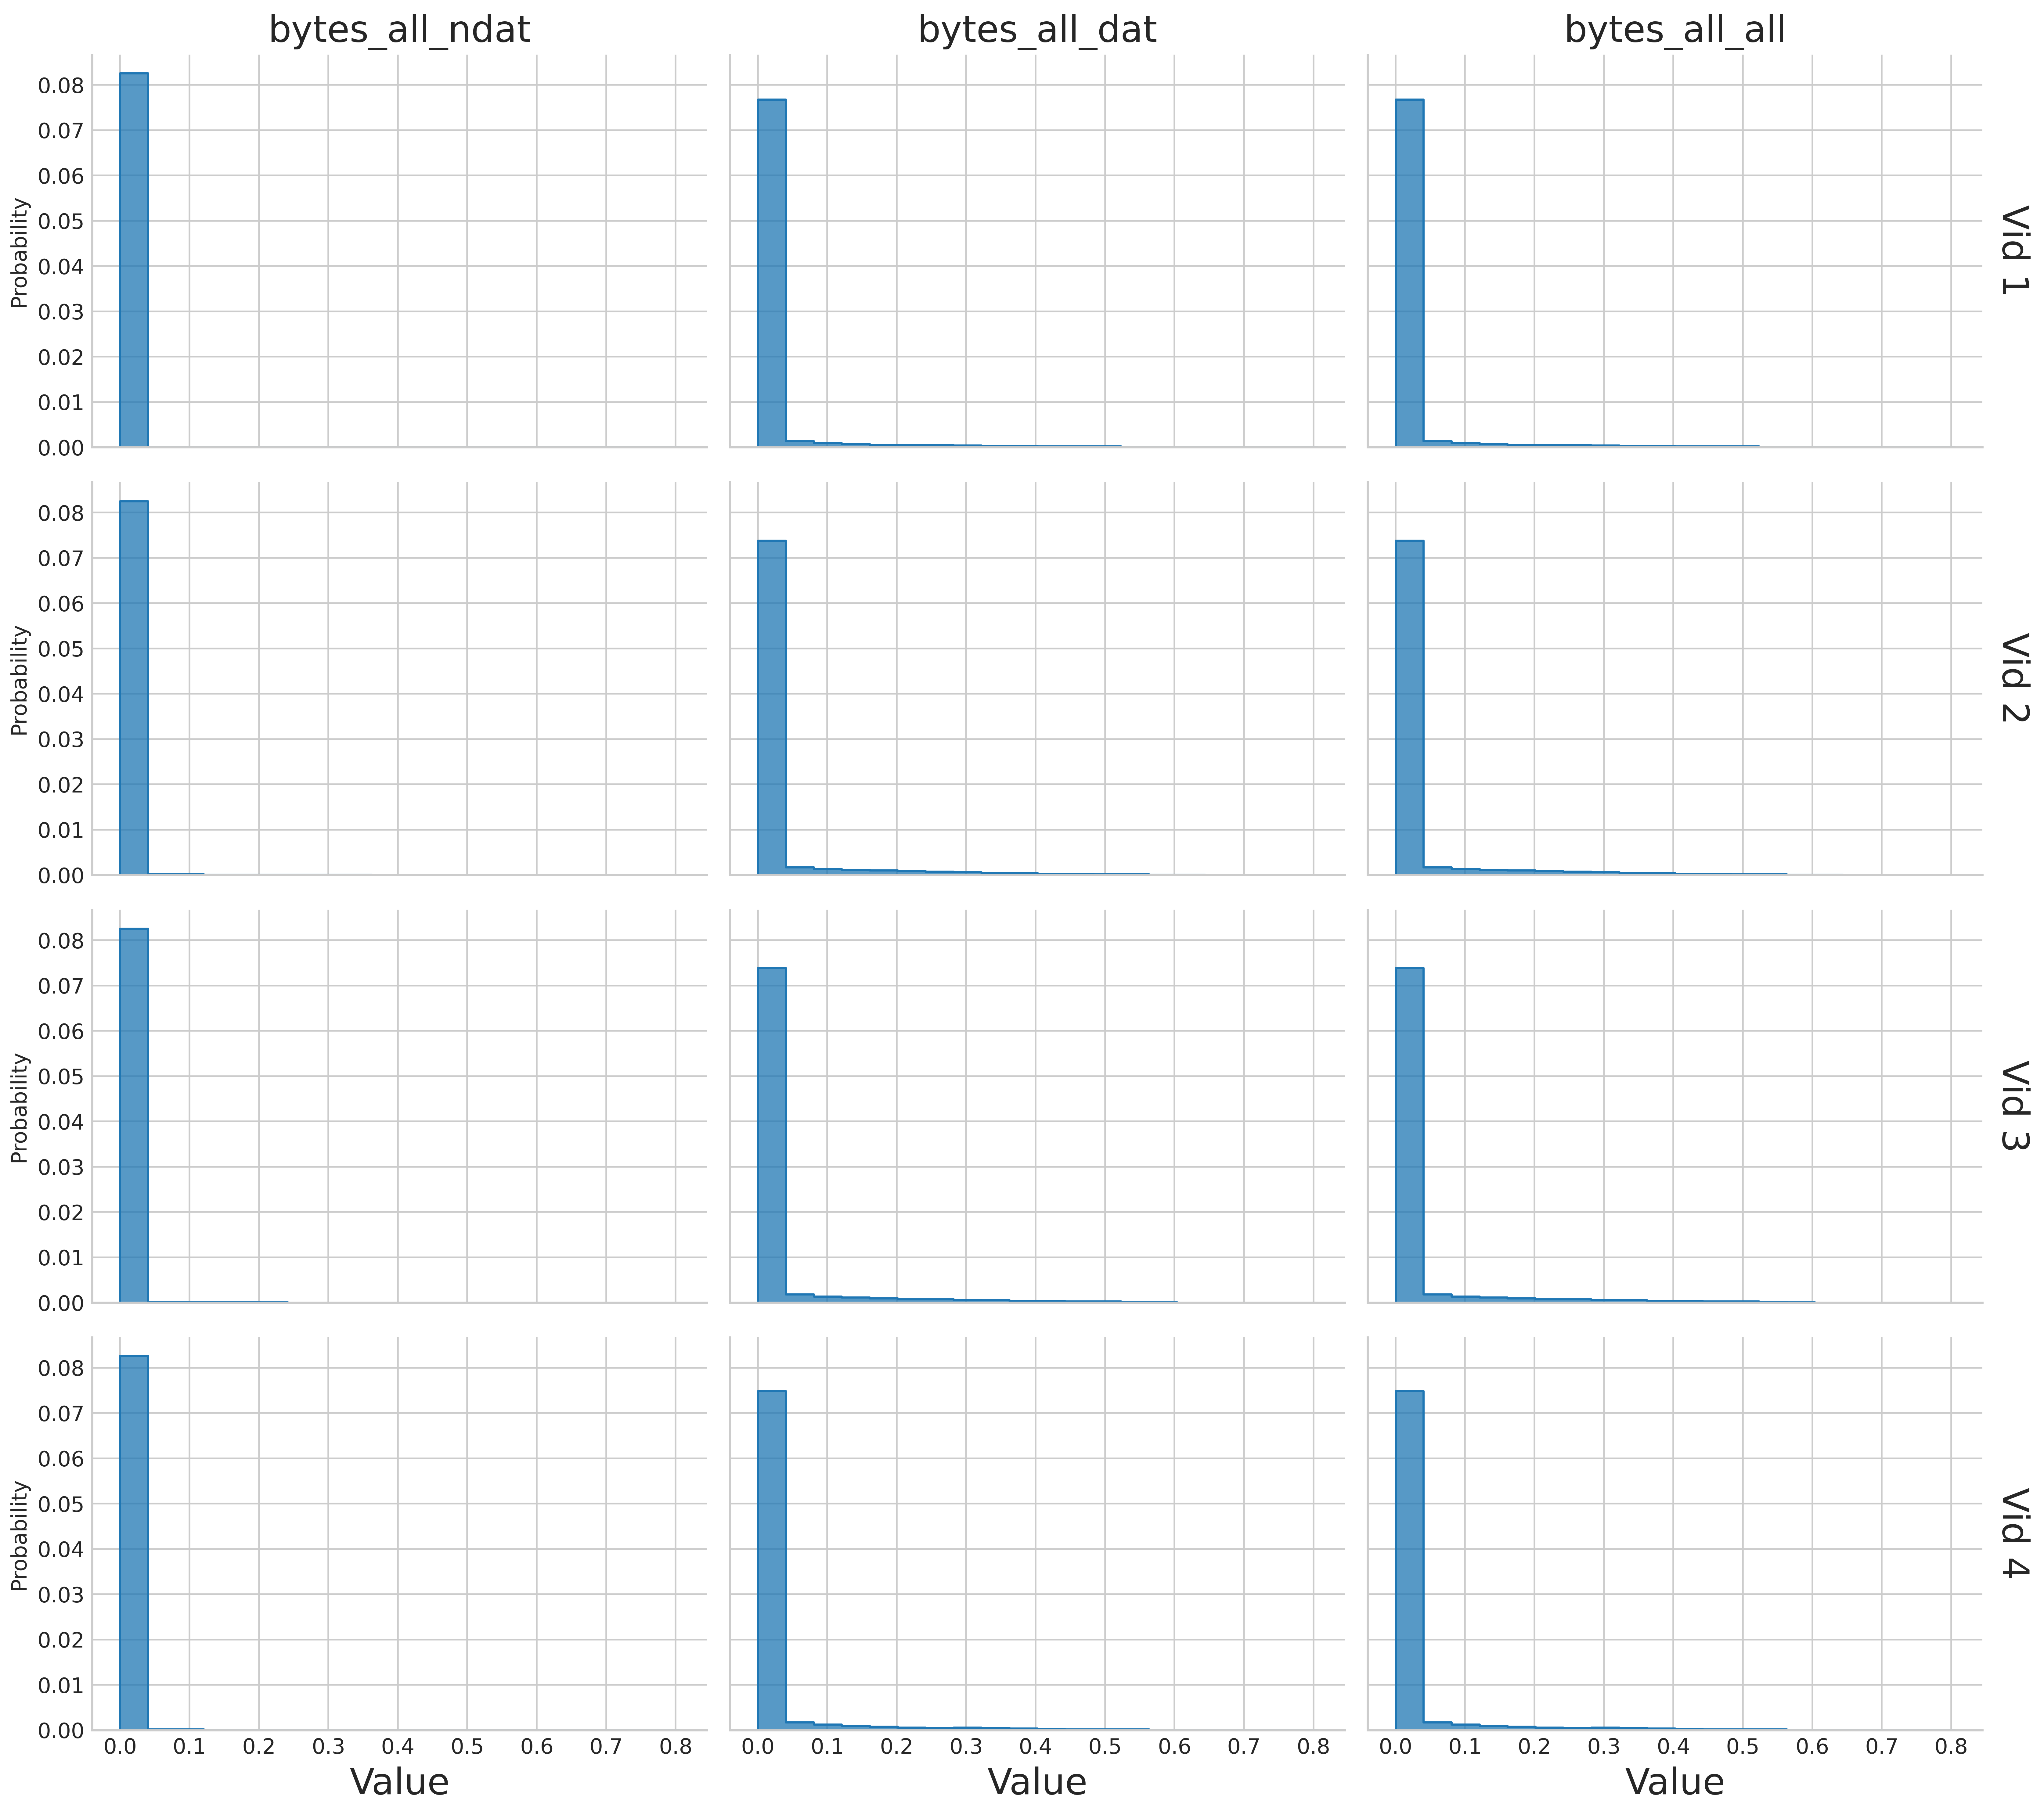

In [10]:
# Histogram of each instance's features
# faceted by labels (rows) and features channels (columns)

data = long_X_features(
    X_features_matr_scaled,
    y,
    feature_channels,
    interval=0.36,
    n=4,
    m=100,
)

with plt.style.context(fig_style):
    g = (
        sns.displot(
            data=data,
            x="value",
            row="label",
            col="feature",
            palette="crest",
            kind="hist",
            stat="probability",
            element="step",
            legend=False,
            # alpha=0.5,
            height=2,
            aspect=1.5,
            bins=20,
            facet_kws={"margin_titles": True},
        )
        # .set(ylim=(0, 10))
        .set_titles(row_template="{row_name}", col_template="{col_name}", size="xx-large")
        .set_xlabels("Value", size="xx-large")
        .tight_layout()
    )

### Making Training and Test sets

In [11]:
# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_features_matr_scaled,
    y_lb,
    test_size=0.2,
    random_state=42,
    stratify=y_lb,
)

# Flattening this data (reshaping) to feed into different ML algos
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3859, 500, 3)
(965, 500, 3)
(3859, 9)
(965, 9)


## Evaluating ML Models

### Helper Funcs to save and eval models

In [12]:
def get_my_model_dir(
    name,
):
    """
    Returns the path to the model directory
    """
    # Making directory to store model
    outcomes = "_".join([i[0] for i in labels_to_classify]) # first letter of every class group
    my_model_dir = os.path.join(models_dir, outcomes, name)
    os.makedirs(my_model_dir, exist_ok=True)
    return my_model_dir


def save_pkl(
    obj,
    name,
    suffix=""
):
    """
    Saves the object as a .pkl file to a folder (given by name)
    """
    my_model_dir = get_my_model_dir(name)
    # Storing object as pickle
    obj_fp = os.path.join(my_model_dir, f"{name}_{suffix}.pkl")
    with open(obj_fp, "wb") as f:
        pickle.dump(obj, f)


def load_pkl(
    name,
    suffix=""
):
    """
    Loads the .pkl file object from a folder (given by name)
    """
    my_model_dir = get_my_model_dir(name)
    # Getting filepaths
    obj_fp = os.path.join(my_model_dir, f"{name}_{suffix}.pkl")
    # Loading object
    with open(obj_fp, "rb") as f:
        obj = pickle.load(f)
    return obj


def save_res(
    y_true,
    y_pred,
    name,
):
    """
    Saves the results to a folder (given by name)
    """
    my_model_dir = get_my_model_dir(name)
    # Generating and storing results as h5
    res_fp = os.path.join(my_model_dir, f"{name}_res.h5")
    pd.DataFrame(
        {
            "y_true": y_true,
            "y_pred": y_pred,
        }
    ).to_hdf(res_fp, key="results", mode="w")


def plot_confusion_matrix(
    cm,
    classes,
    title='Confusion matrix',
    **kwargs
):
    """
    To plot heatmap of confusion matrix
    """
    # Initialising figure and axes
    with plt.style.context(fig_style):
        fig = plt.figure(
            figsize=(8, 8),
            layout="constrained"
        )
        ax = fig.subplots()
    # Making confusion matrix heatmap
    sns.heatmap(
        cm,
        annot=kwargs.get("annot", False),
        ax=ax,
        cmap=kwargs.get("cmap", cmap_intsy),
        fmt=kwargs.get("fmt", ".2f"),
        cbar=kwargs.get("cbar", True),
        xticklabels=classes,
        yticklabels=classes,
    )
    # Set titles
    ax.tick_params(labelsize="small")
    ax.set_title(title, fontsize="xx-large")
    ax.set_xlabel("Predicted", fontsize="large")
    ax.set_ylabel("True", fontsize="large")
    # Return figure and axis
    return fig, ax

def eval_model(
    name,
    lab_grouping=None,
):
    """
    Evaluate the given model from the saved results h5.
    Can also group on the given labels (e.g., only (devices, videos))
    """
    my_model_dir = get_my_model_dir(name)
    # Reading in results
    res = pd.read_hdf(
        os.path.join(my_model_dir, f"{name}_res.h5"),
        key="results",
        more="r"
    )
    # Making label groupings for evaluation
    if lab_grouping:
        res = res.assign(
            y_true=lambda x: ["|".join(i) for i in np.array(res["y_true"].str.split("|").values.tolist())[:, lab_grouping]],
            y_pred=lambda x: ["|".join(i) for i in np.array(res["y_pred"].str.split("|").values.tolist())[:, lab_grouping]],
        )

    # Getting classes
    classes = np.sort(res["y_true"].unique())

    # Making confusion matrix
    # rows = true, columns = predicted
    cm = confusion_matrix(
        y_true=res["y_true"],
        y_pred=res["y_pred"],
        labels=classes,
        normalize=None,
    )
    # Plotting confusion matrix
    fig, ax = plot_confusion_matrix(
        cm,
        classes,
        title=f"{name} Classifier Results",
        annot=True,
        cmap="Blues",
        fmt=".0f",
    )
    fig.savefig(os.path.join(my_model_dir, f"{name}_cm.png"))
    # Classification report
    print(classification_report(
        res["y_true"],
        res["y_pred"],
        target_names=classes,
    ))
    (
        pd.DataFrame(classification_report(
            res["y_true"],
            res["y_pred"],
            target_names=classes,
            output_dict=True,
        ))
        .transpose()
        .to_csv(os.path.join(my_model_dir, f"{name}_report.csv"))
    )


### KNN

              precision    recall  f1-score   support

       Vid 1       0.51      0.49      0.50       111
       Vid 2       0.53      0.45      0.49        87
       Vid 3       0.88      0.84      0.86       117
       Vid 4       0.77      0.77      0.77       117
       Vid 5       0.64      0.59      0.61        97
       Vid 6       0.45      0.69      0.55       112
       Vid 7       0.82      0.72      0.76       113
       Vid 8       0.82      0.71      0.76       101
       Vid 9       0.56      0.56      0.56       110

    accuracy                           0.65       965
   macro avg       0.66      0.65      0.65       965
weighted avg       0.67      0.65      0.66       965



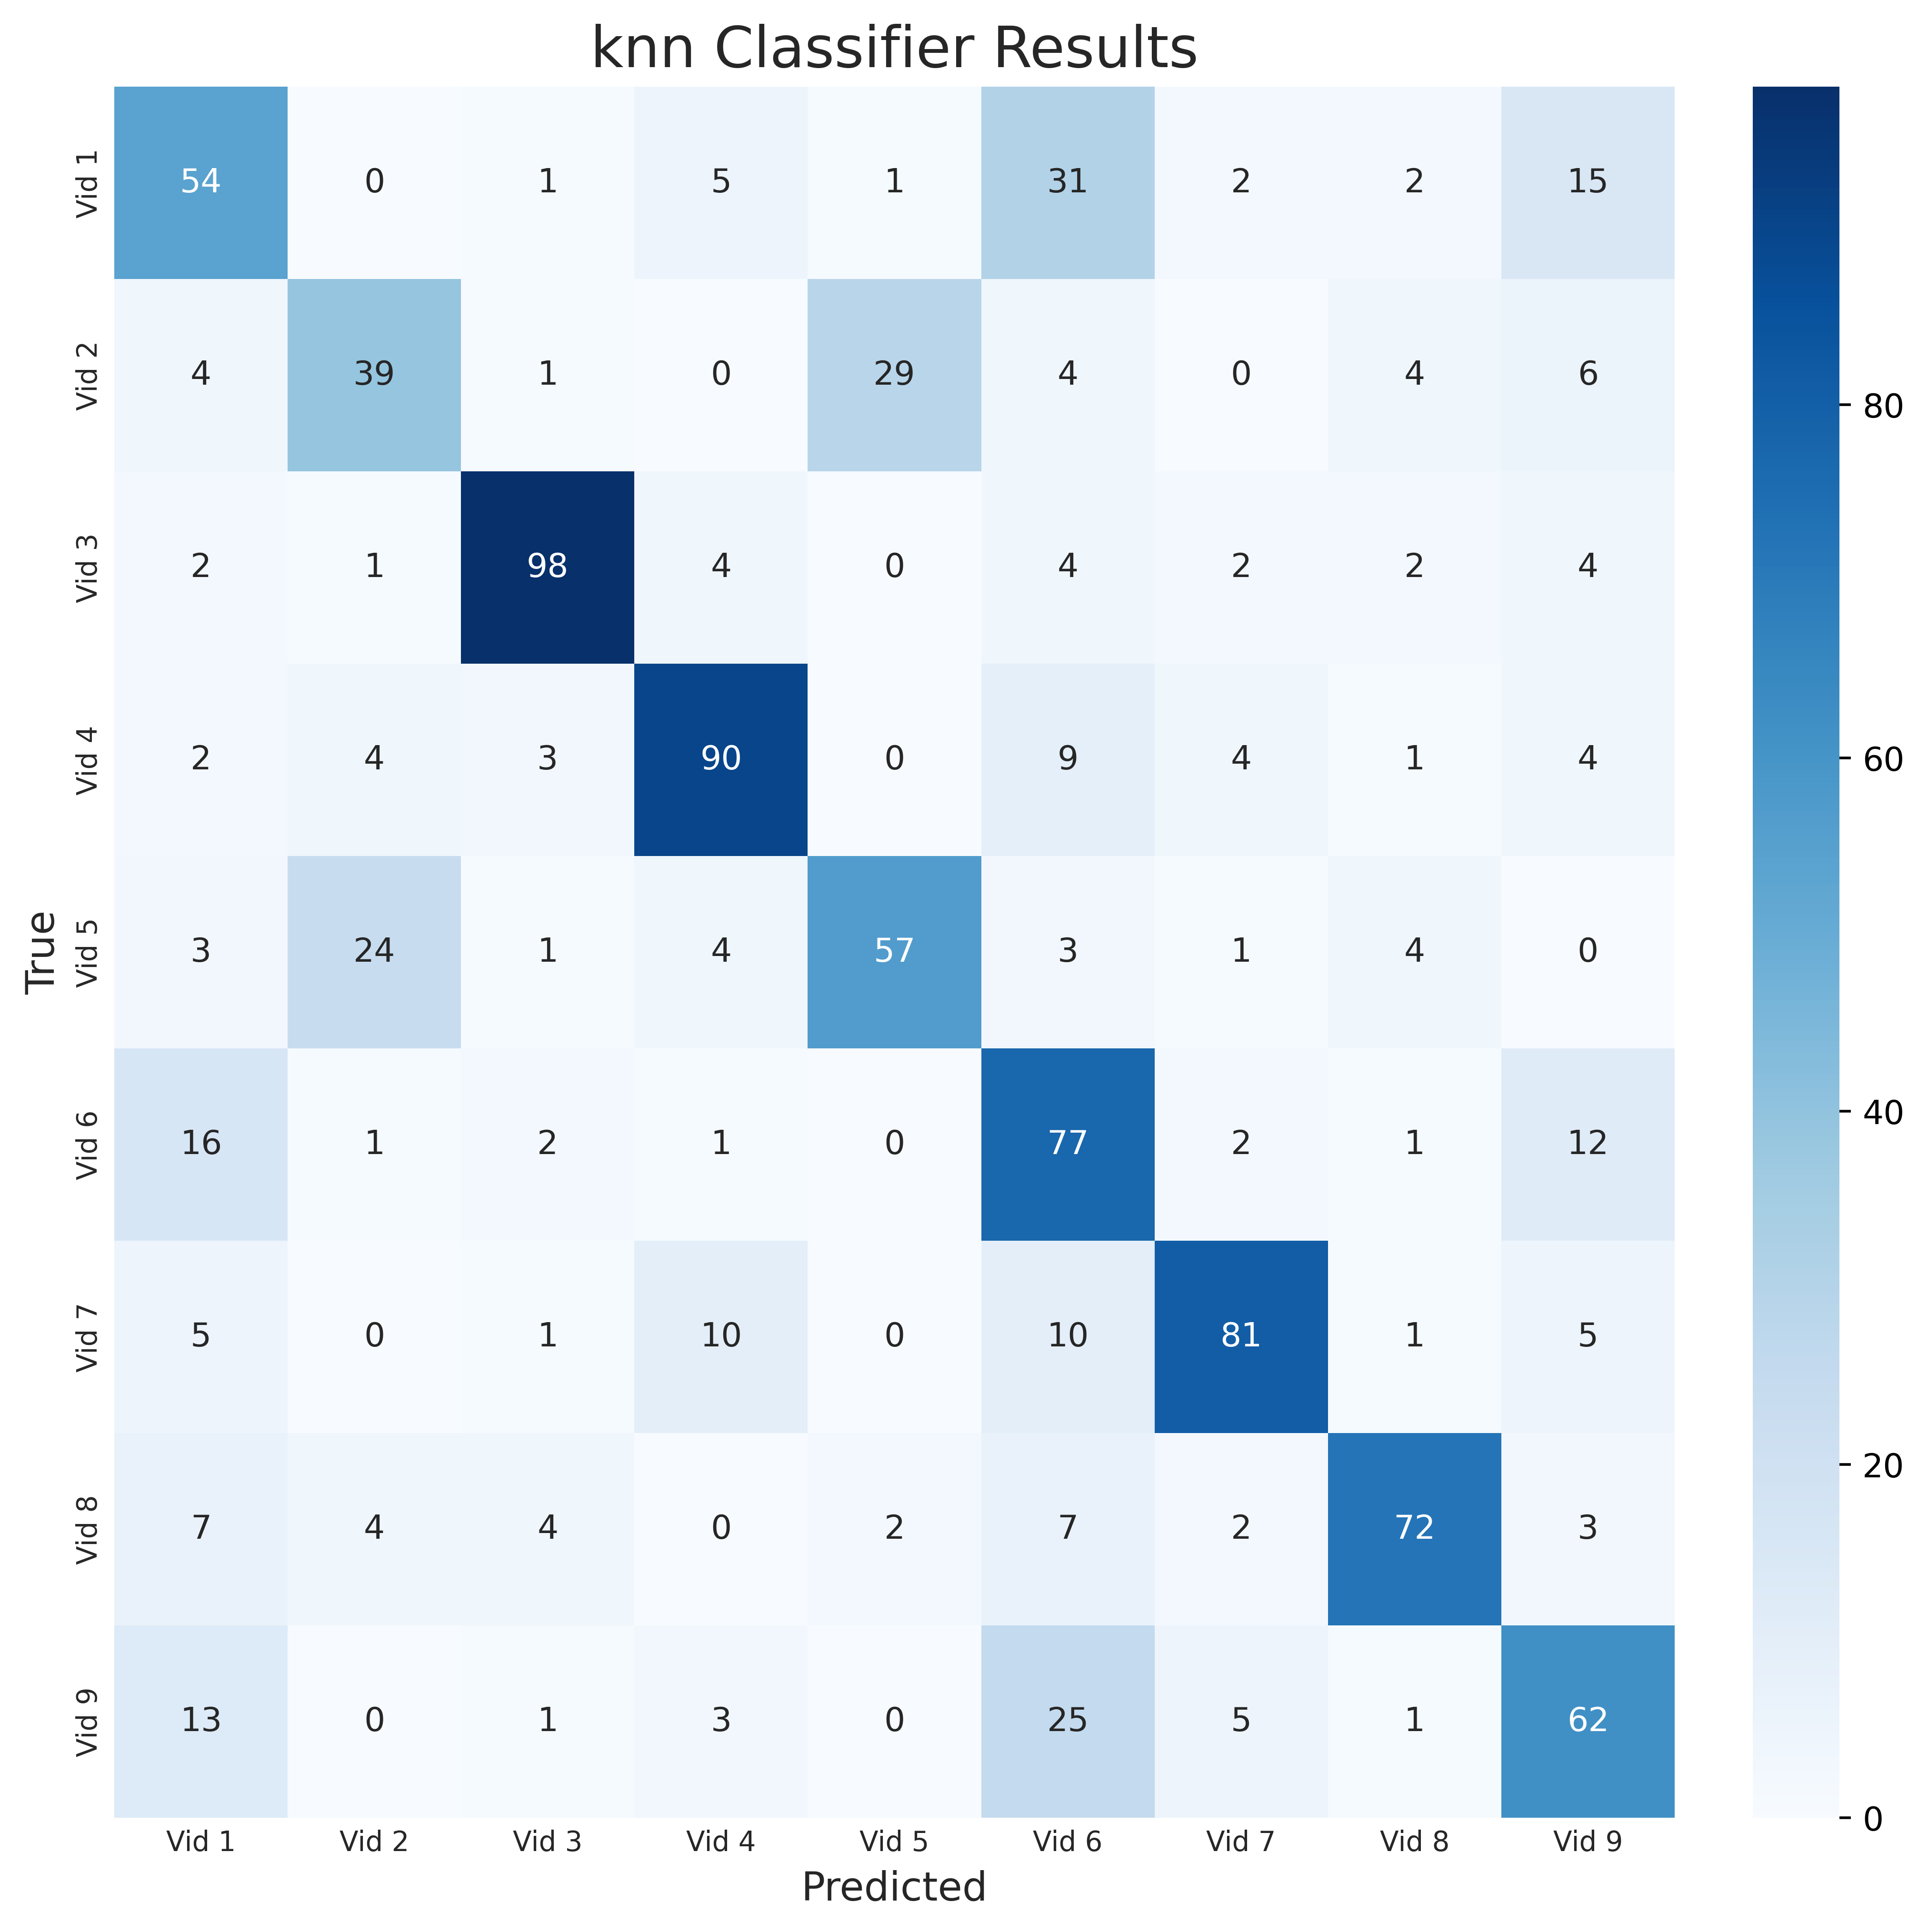

In [13]:
# KNN WORKS VERY WELL ~ 0.64 accuracy.
# 1-NN seems to work best

name = "knn"

# Making KNN
model = KNeighborsClassifier(
    n_neighbors=1,
    weights='uniform',
    algorithm='auto',
    leaf_size=30,
    p=2,
    metric='minkowski',
    metric_params=None,
    n_jobs=None
)

# Training
model.fit(X_train_flat, y_train)

# Saving the model
save_pkl(
    model,
    name,
    suffix="model",
)

# Evaluating (from saved model)
model = load_pkl(
    name,
    suffix="model",
)
y_pred = model.predict(X_test_flat)

# Saving the results
save_res(
    lb.inverse_transform(y_test),
    lb.inverse_transform(y_pred),
    name,
)
# Showing results
eval_model(name, [0])

### SVM (One vs Rest)

In [14]:
# # SVM OVR is similar performance to KNN but much slower to train

# name = "svc_ovr"

# # Making RBF SVC
# model = SVC(
#     C=2.0, # Regularisation parameter. Reg strength is inversely proportional to C
#     kernel='rbf', # {‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’} or callable
#     # degree=3, # Degree for poly kernels
#     gamma='scale', # {‘scale’, ‘auto’} or float
#     coef0=0.0, # Independent term in kernel function. It is only significant in ‘poly’ and ‘sigmoid’.
#     shrinking=True, # Whether to use the shrinking heuristic
#     probability=False, # Allows predict_proba but slows down process
#     tol=0.001, # Tolerance for stopping criterion.
#     cache_size=200, # Specify the size of the kernel cache in MB
#     class_weight=None, # Set the parameter C of class i to class_weight[i]*C. Keep as none for equal weights across classes
#     verbose=False, # Enable verbose output
#     max_iter=-1, # Hard limit on iterations within solver, or -1 for no limit
#     decision_function_shape='ovo', # {‘ovo’, ‘ovr’}
#     break_ties=False,
#     random_state=None
# )
# model = OneVsRestClassifier(
#     model,
#     n_jobs=4,
# )

# # Training
# model.fit(X_train_flat, y_train)

# # Saving the model
# save_pkl(
#     model,
#     name,
#     suffix="model",
# )

# # Evaluating (from saved model)
# model = load_pkl(
#     name,
#     suffix="model",
# )
# y_pred = model.predict(X_test_flat)

# # Saving the results
# save_res(
#     lb.inverse_transform(y_test),
#     lb.inverse_transform(y_pred),
#     name,
# )
# # Showing results
# eval_model(name, [0])

### SVM (One vs One)

              precision    recall  f1-score   support

       Vid 1       0.64      0.74      0.68       111
       Vid 2       0.76      0.54      0.63        87
       Vid 3       0.92      0.85      0.88       117
       Vid 4       0.92      0.83      0.87       117
       Vid 5       0.72      0.74      0.73        97
       Vid 6       0.67      0.67      0.67       112
       Vid 7       0.94      0.77      0.84       113
       Vid 8       0.81      0.92      0.86       101
       Vid 9       0.59      0.75      0.66       110

    accuracy                           0.76       965
   macro avg       0.77      0.76      0.76       965
weighted avg       0.77      0.76      0.76       965



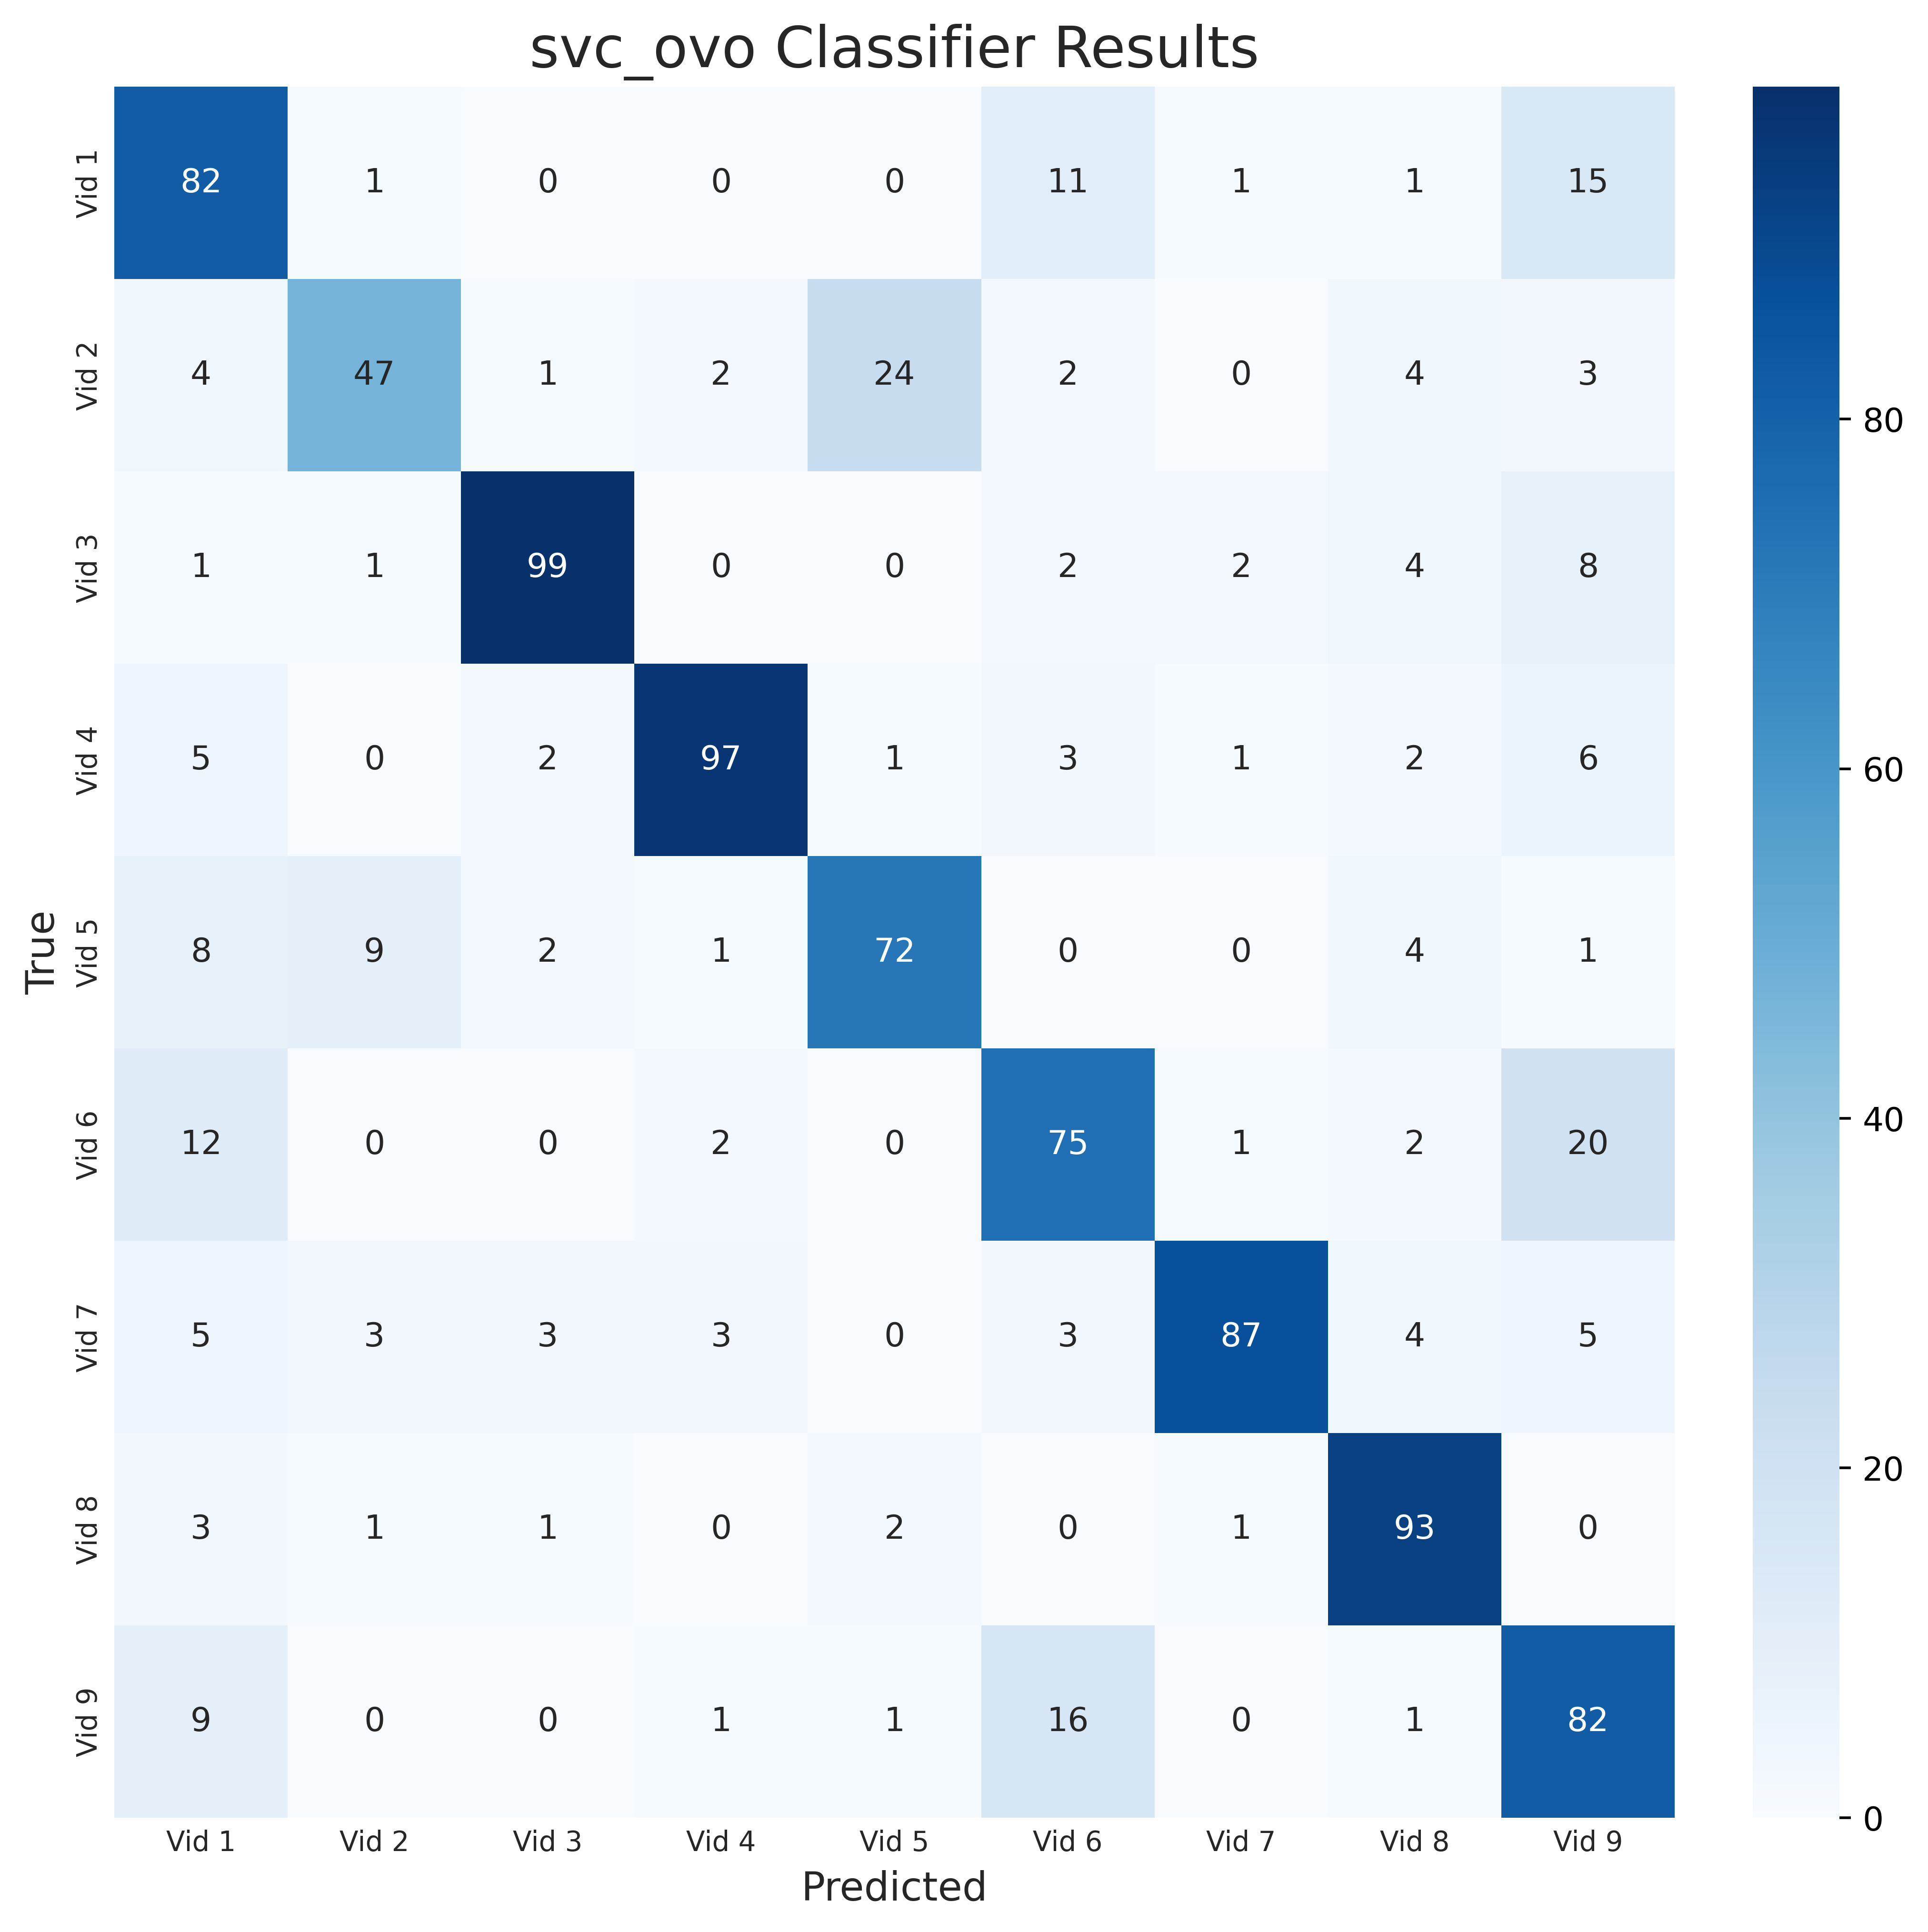

In [15]:
# SVM OVO is ~ 0.78% accuracy.

name = "svc_ovo"

# Making RBF SVC
model = SVC(
    C=2.0, # Regularisation parameter. Reg strength is inversely proportional to C
    kernel='rbf', # {‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’} or callable
    # degree=3, # Degree for poly kernels
    gamma='scale', # {‘scale’, ‘auto’} or float
    coef0=0.0, # Independent term in kernel function. It is only significant in ‘poly’ and ‘sigmoid’.
    shrinking=True, # Whether to use the shrinking heuristic
    probability=False, # Allows predict_proba but slows down process
    tol=0.001, # Tolerance for stopping criterion.
    cache_size=200, # Specify the size of the kernel cache in MB
    class_weight=None, # Set the parameter C of class i to class_weight[i]*C. Keep as none for equal weights across classes
    verbose=False, # Enable verbose output
    max_iter=-1, # Hard limit on iterations within solver, or -1 for no limit
    decision_function_shape='ovo', # {‘ovo’, ‘ovr’}
    break_ties=False,
    random_state=None
)
model = OneVsOneClassifier(
    model,
    n_jobs=4,
)

# Converting binarised labels (vectors) to encoded (single val)
le = LabelEncoder()
y_le_train = le.fit_transform(lb.inverse_transform(y_train))
y_le_test = le.transform(lb.inverse_transform(y_test))

# Training
model.fit(X_train_flat, y_le_train)

# Saving the model
save_pkl(
    model,
    name,
    suffix="model",
)

# Evaluating (from saved model)
model = load_pkl(
    name,
    suffix="model",
)
y_pred = model.predict(X_test_flat)

# Saving the results
save_res(
    le.inverse_transform(y_le_test),
    le.inverse_transform(y_pred),
    name,
)
# Showing results
eval_model(name, [0])

## Deep Learning Models

In [16]:
def save_model_tf(
    model,
    name,

):
    """
    Saves the TensorFlow Keras model to a folder (given by name)
    """
    my_model_dir = get_my_model_dir(name)
    # Storing model as .keras
    model_fp = os.path.join(my_model_dir, f"{name}.keras")
    model.save(model_fp)

def save_weights_tf(
    model,
    name,
):
    """
    Saves the TensorFlow Keras model weights to a folder (given by name)
    """
    my_model_dir = get_my_model_dir(name)
    # Storing model as .keras
    weights_fp = os.path.join(my_model_dir, f"{name}")
    model.save_weights(weights_fp)


def save_architecture_tf(
    model,
    name
):
    """
    Saves the TensorFlow Keras model architecture to a folder (given by name)
    """
    my_model_dir = get_my_model_dir(name)
    # Saving architecture diagram
    archt_fp = os.path.join(my_model_dir, f"{name}.png")
    tf_plot(
        model,
        to_file=archt_fp,
        show_shapes=True,
        show_dtype=True,
        show_layer_names=False,
        rankdir="TB",
        expand_nested=True,
        show_layer_activations=True,
        show_trainable=False,
    )


def load_model_tf(
    name,
    load_weights=True,
):
    """
    Loads the TensorFlow Keras model from a folder (given by name)
    """
    my_model_dir = get_my_model_dir(name)
    # Getting filepaths
    model_fp = os.path.join(my_model_dir, f"{name}.keras")
    weights_fp = os.path.join(my_model_dir, f"{name}")
    # Loading model
    model = tf_load_model(model_fp)
    # Loading best weights
    if load_weights:
        try:
            model.load_weights(weights_fp)
        except:
            pass
    return model


def make_checkpoint_cb(name):
    """
    Make the ModelCheckpoint callback to save the model during training.
    """
    my_model_dir = get_my_model_dir(name)
    os.makedirs(my_model_dir, exist_ok=True)
    # Making model checkpoint callback
    checkpoint_fp = os.path.join(my_model_dir, f"{name}")
    cp_callback = ModelCheckpoint(
        filepath=checkpoint_fp,
        verbose=1,
        save_weights_only=True,
        save_freq="epoch",
        monitor="val_categorical_accuracy",
        mode="max",
        save_best_only=True,
    )
    # Returning callback
    return cp_callback


def train_tf(
    name,
    hparams,
    X_train,
    y_train,
):
    """
    Trains a TensorFlow Keras model.
    Steps are:
        - Configure the model for training
        - Training the model
        - Saving the model
    """
    my_model_dir = get_my_model_dir(name)
    # Loading model
    model = load_model_tf(name, load_weights=False)

    # Remove old weights
    for i in ["checkpoint", ".index", ".data"]:
        fps = glob(os.path.join(my_model_dir, f"*{i}*"))
        [os.remove(fp) for fp in fps]

    # Configure the model for training
    model.compile(
        optimizer=Adam(
            learning_rate=hparams["learning_rate"],
        ),
        loss=hparams["loss"],
        metrics=[
            CategoricalAccuracy(),
            BinaryAccuracy(),
        ],
        loss_weights=None,
        weighted_metrics=None,
        run_eagerly=None,
        steps_per_execution=None,
        jit_compile=None,
        # pss_evaluation_shards=0,
    )

    # Training the model
    history = model.fit(
        X_train,
        y_train,
        epochs=hparams["epochs"],
        batch_size=hparams["batch_size"],
        validation_split=hparams["validation_split"],
        verbose=hparams["verbose"],
        callbacks=[
            make_checkpoint_cb(name),
            EarlyStopping(
                monitor=hparams["stopping_monitor"],
                min_delta=0,
                patience=10,
                verbose=1,
                mode="auto",
                baseline=0,
                restore_best_weights=False,
                start_from_epoch=0,
            )
        ],
        use_multiprocessing=True,
    )

    # Saving the model
    save_model_tf(model, name)
    # Saving model history
    save_pkl(
        history,
        name,
        suffix="history",
    )
    # Saving model hyperparams
    save_pkl(
        hparams,
        name,
        suffix="hparams",
    )

def eval_tf(
    name,
    X_test,
    y_test,
    lab_grouping=None,
    metrics=["loss", "categorical_accuracy"]
):
    """
    Evaluates a TensorFlow Keras model.
    Steps are:
        - Evaluating (from saved model)
        - Saving the results
        - Showing results
    """
    my_model_dir = get_my_model_dir(name)
    # Loading model
    model = load_model_tf(name)

    # Predicting the test labels
    y_pred = model.predict(X_test)

    # Saving the results
    save_res(
        lb.inverse_transform(y_test),
        lb.inverse_transform(y_pred),
        name,
    )
    # Showing results
    eval_model(name, lab_grouping)

    # Showing training convergence
    # Loading history
    history = load_pkl(name, suffix="history")
    h = pd.DataFrame(history.history)
    # Plotting training accuracy and loss convergence
    with plt.style.context(fig_style):
        fig, axes = plt.subplots(ncols=2)
    for i_k, i_v in enumerate(metrics):
        sns.lineplot(
            data=(
                h[[f"{j}{i_v}" for j in ["", "val_"]]]
                .melt(
                    var_name="variable",
                    value_name="value",
                    ignore_index=False)
                .reset_index(
                    names="epoch",
                )
            ),
            x="epoch",
            y="value",
            hue="variable",
            palette=cmap_qual,
            ax=axes[i_k],
        )
        axes[i_k].set_title(f"{i_v}")
    fig.savefig(os.path.join(my_model_dir, f"{name}_history.png"))


### MLP Model

Model: "MLP_V1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 500, 3)]          0         
                                                                 
 MLP_V1 (Sequential)         (None, 9)                 392777    
                                                                 
Total params: 392777 (1.50 MB)
Trainable params: 392777 (1.50 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
34/49 [===================>..........] - ETA: 0s - loss: 2.0749 - categorical_accuracy: 0.1949 - binary_accuracy: 0.8888
Epoch 1: val_categorical_accuracy improved from -inf to 0.52979, saving model to /content/drive/MyDrive/honours/models/wlan/v/MLP_V1/MLP_V1
49/49 [==============================] - 3s 10ms/step - loss: 2.0028 - categorical_accuracy: 0.2452 - binary_accuracy: 0.8891 - val_loss: 1.6643 - 

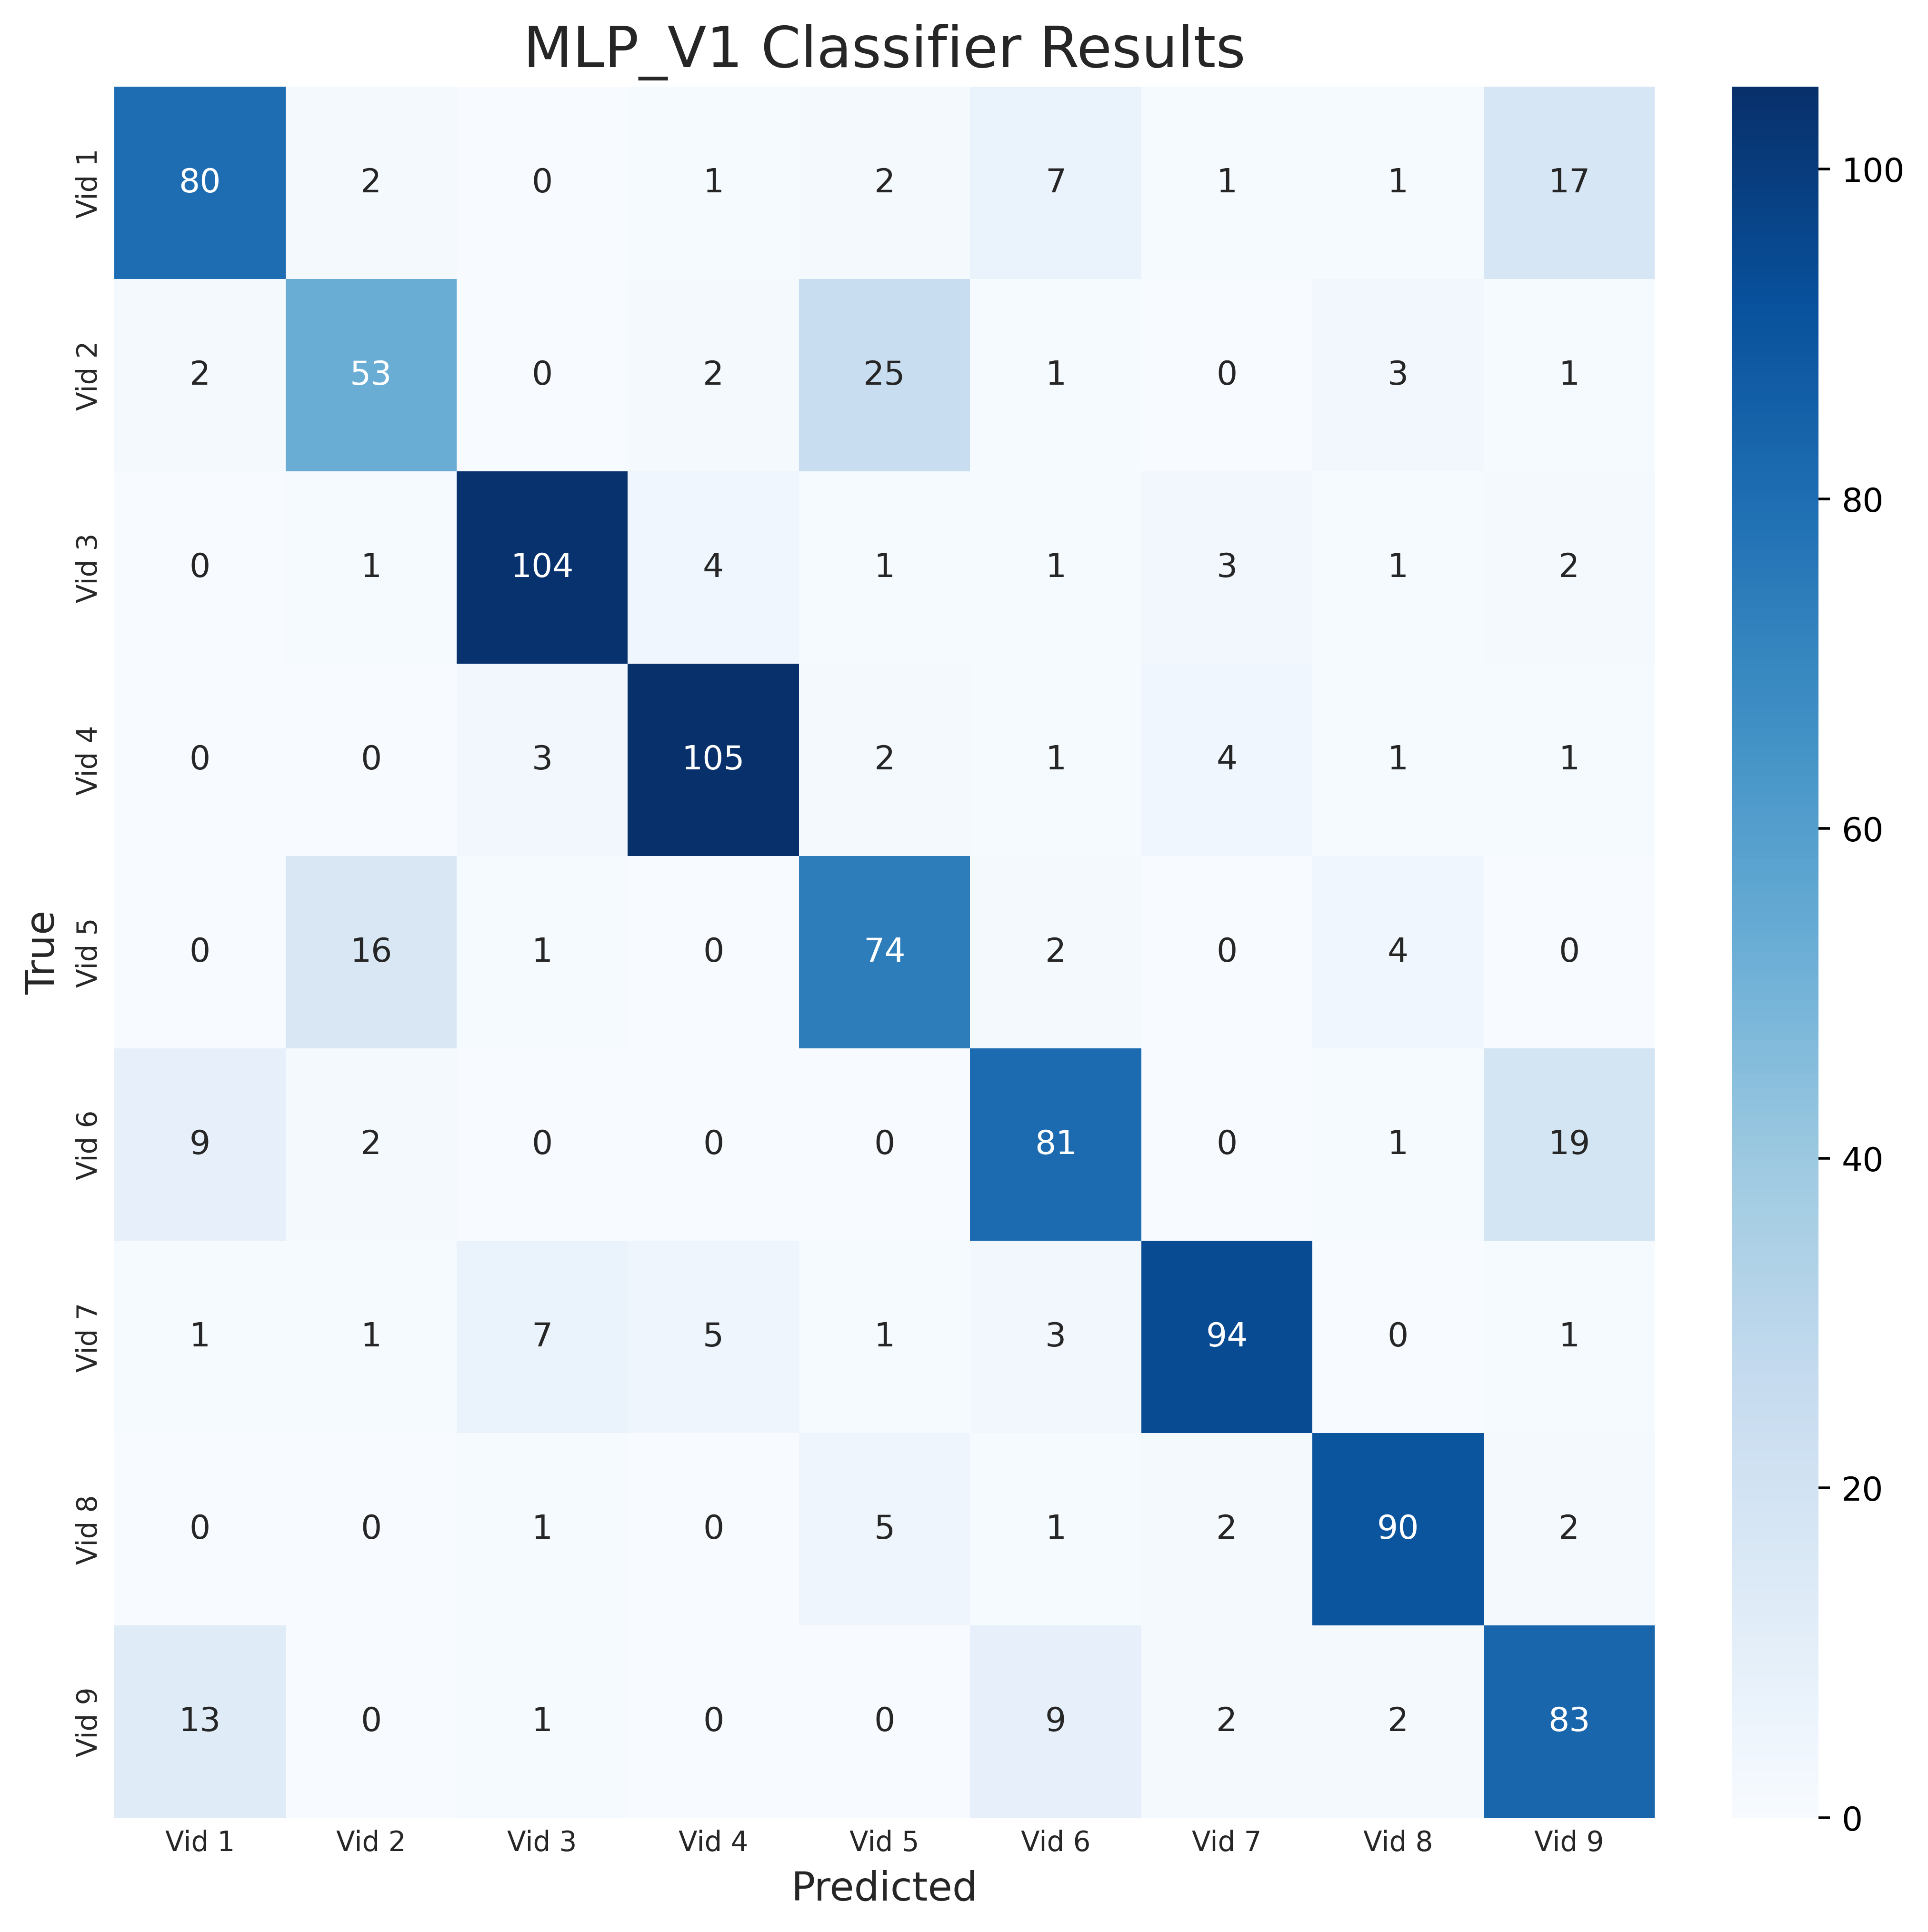

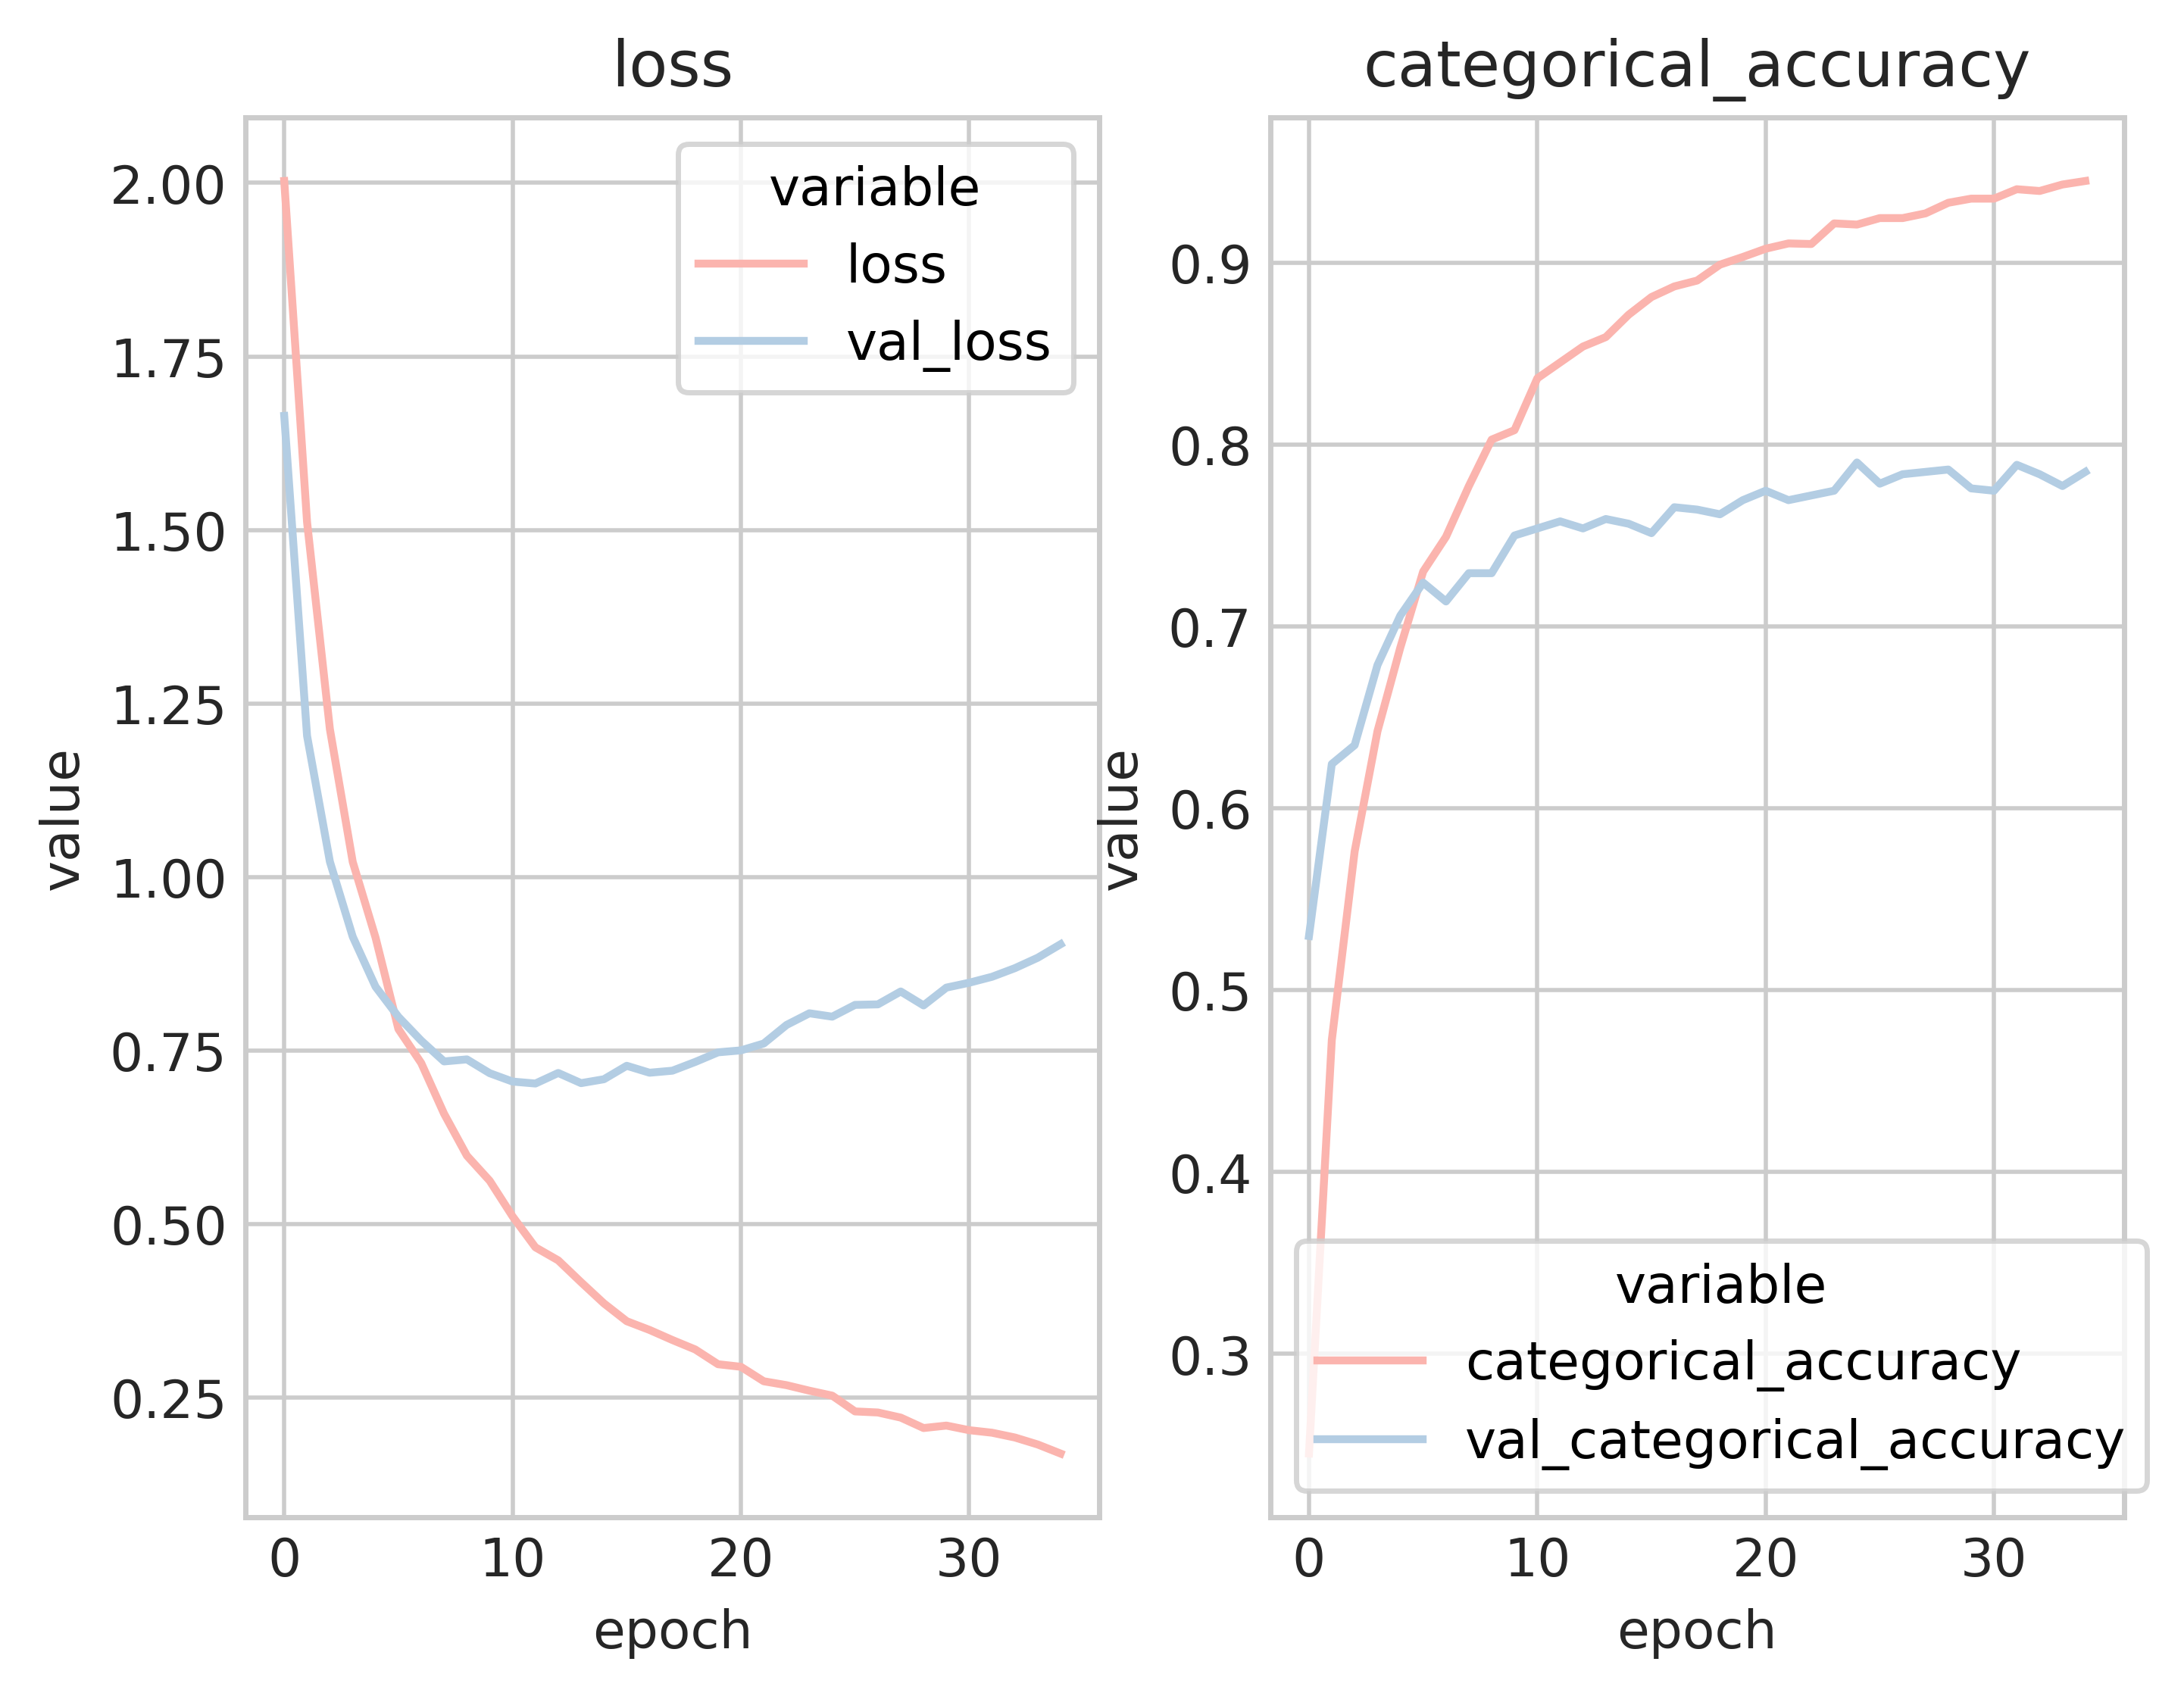

In [17]:
name = "MLP_V1"

# Hyper-parameters
hparams = {
    "epochs": 100,
    "batch_size": 64,
    "validation_split": 0.2,
    "verbose": True,
    "learning_rate": 0.001,
    "loss": CategoricalCrossentropy(), # FOR CATEGORICAL CLASSIFICATION
    "stopping_monitor":"val_categorical_accuracy", # FOR CATEGORICAL CLASSIFICATION
    # "loss": BinaryCrossentropy(), # FOR BINARY CLASSIFICATION
    # "stopping_monitor":"val_binary_accuracy", # FOR BINARY CLASSIFICATION
}

# Making MLP model Architecture
in1 = Input(shape=X_train.shape[1:])
m1 = Sequential(
    [
        Flatten(
            name="flatten",
        ),
        Dense(
            256, activation="relu", name="dense_1",
        ),
        Dense(
            32, activation="relu", name="dense_2",
        ),
        Dropout(
            0.5, name="dropout_1"
        ),
        Dense( # FOR CATEGORICAL CLASSIFICATION
            len(lb.classes_), activation="softmax", name="output"
        ),
        # Dense( # FOR BINARY CLASSIFICATION
        #     1, activation="sigmoid", name="output"
        # ),
    ],
    name="MLP_V1"
)(in1)

model = Model(
    inputs=[in1],
    outputs=[m1],
    name=name,
)

# Show model architecture
model.summary()

# Saving model
save_model_tf(model, name)
# Save architecture
save_architecture_tf(model, name)

# Training model
train_tf(name, hparams, X_train, y_train)

# Evaluating model
eval_tf(
    name,
    X_test,
    y_test,
    lab_grouping=[0],
    # metrics=["loss", "binary_accuracy"],
)


### CNN Model V1

Model: "CNN_V1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 500, 3)]          0         
                                                                 
 CNN_V1 (Sequential)         (None, 9)                 253081    
                                                                 
Total params: 253081 (988.60 KB)
Trainable params: 253081 (988.60 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
49/49 [==============================] - ETA: 0s - loss: 1.7939 - categorical_accuracy: 0.3612 - binary_accuracy: 0.8948
Epoch 1: val_categorical_accuracy improved from -inf to 0.64249, saving model to /content/drive/MyDrive/honours/models/wlan/v/CNN_V1/CNN_V1
49/49 [==============================] - 3s 11ms/step - loss: 1.7939 - categorical_accuracy: 0.3612 - binary_accuracy: 0.8948 - val_loss: 1.134

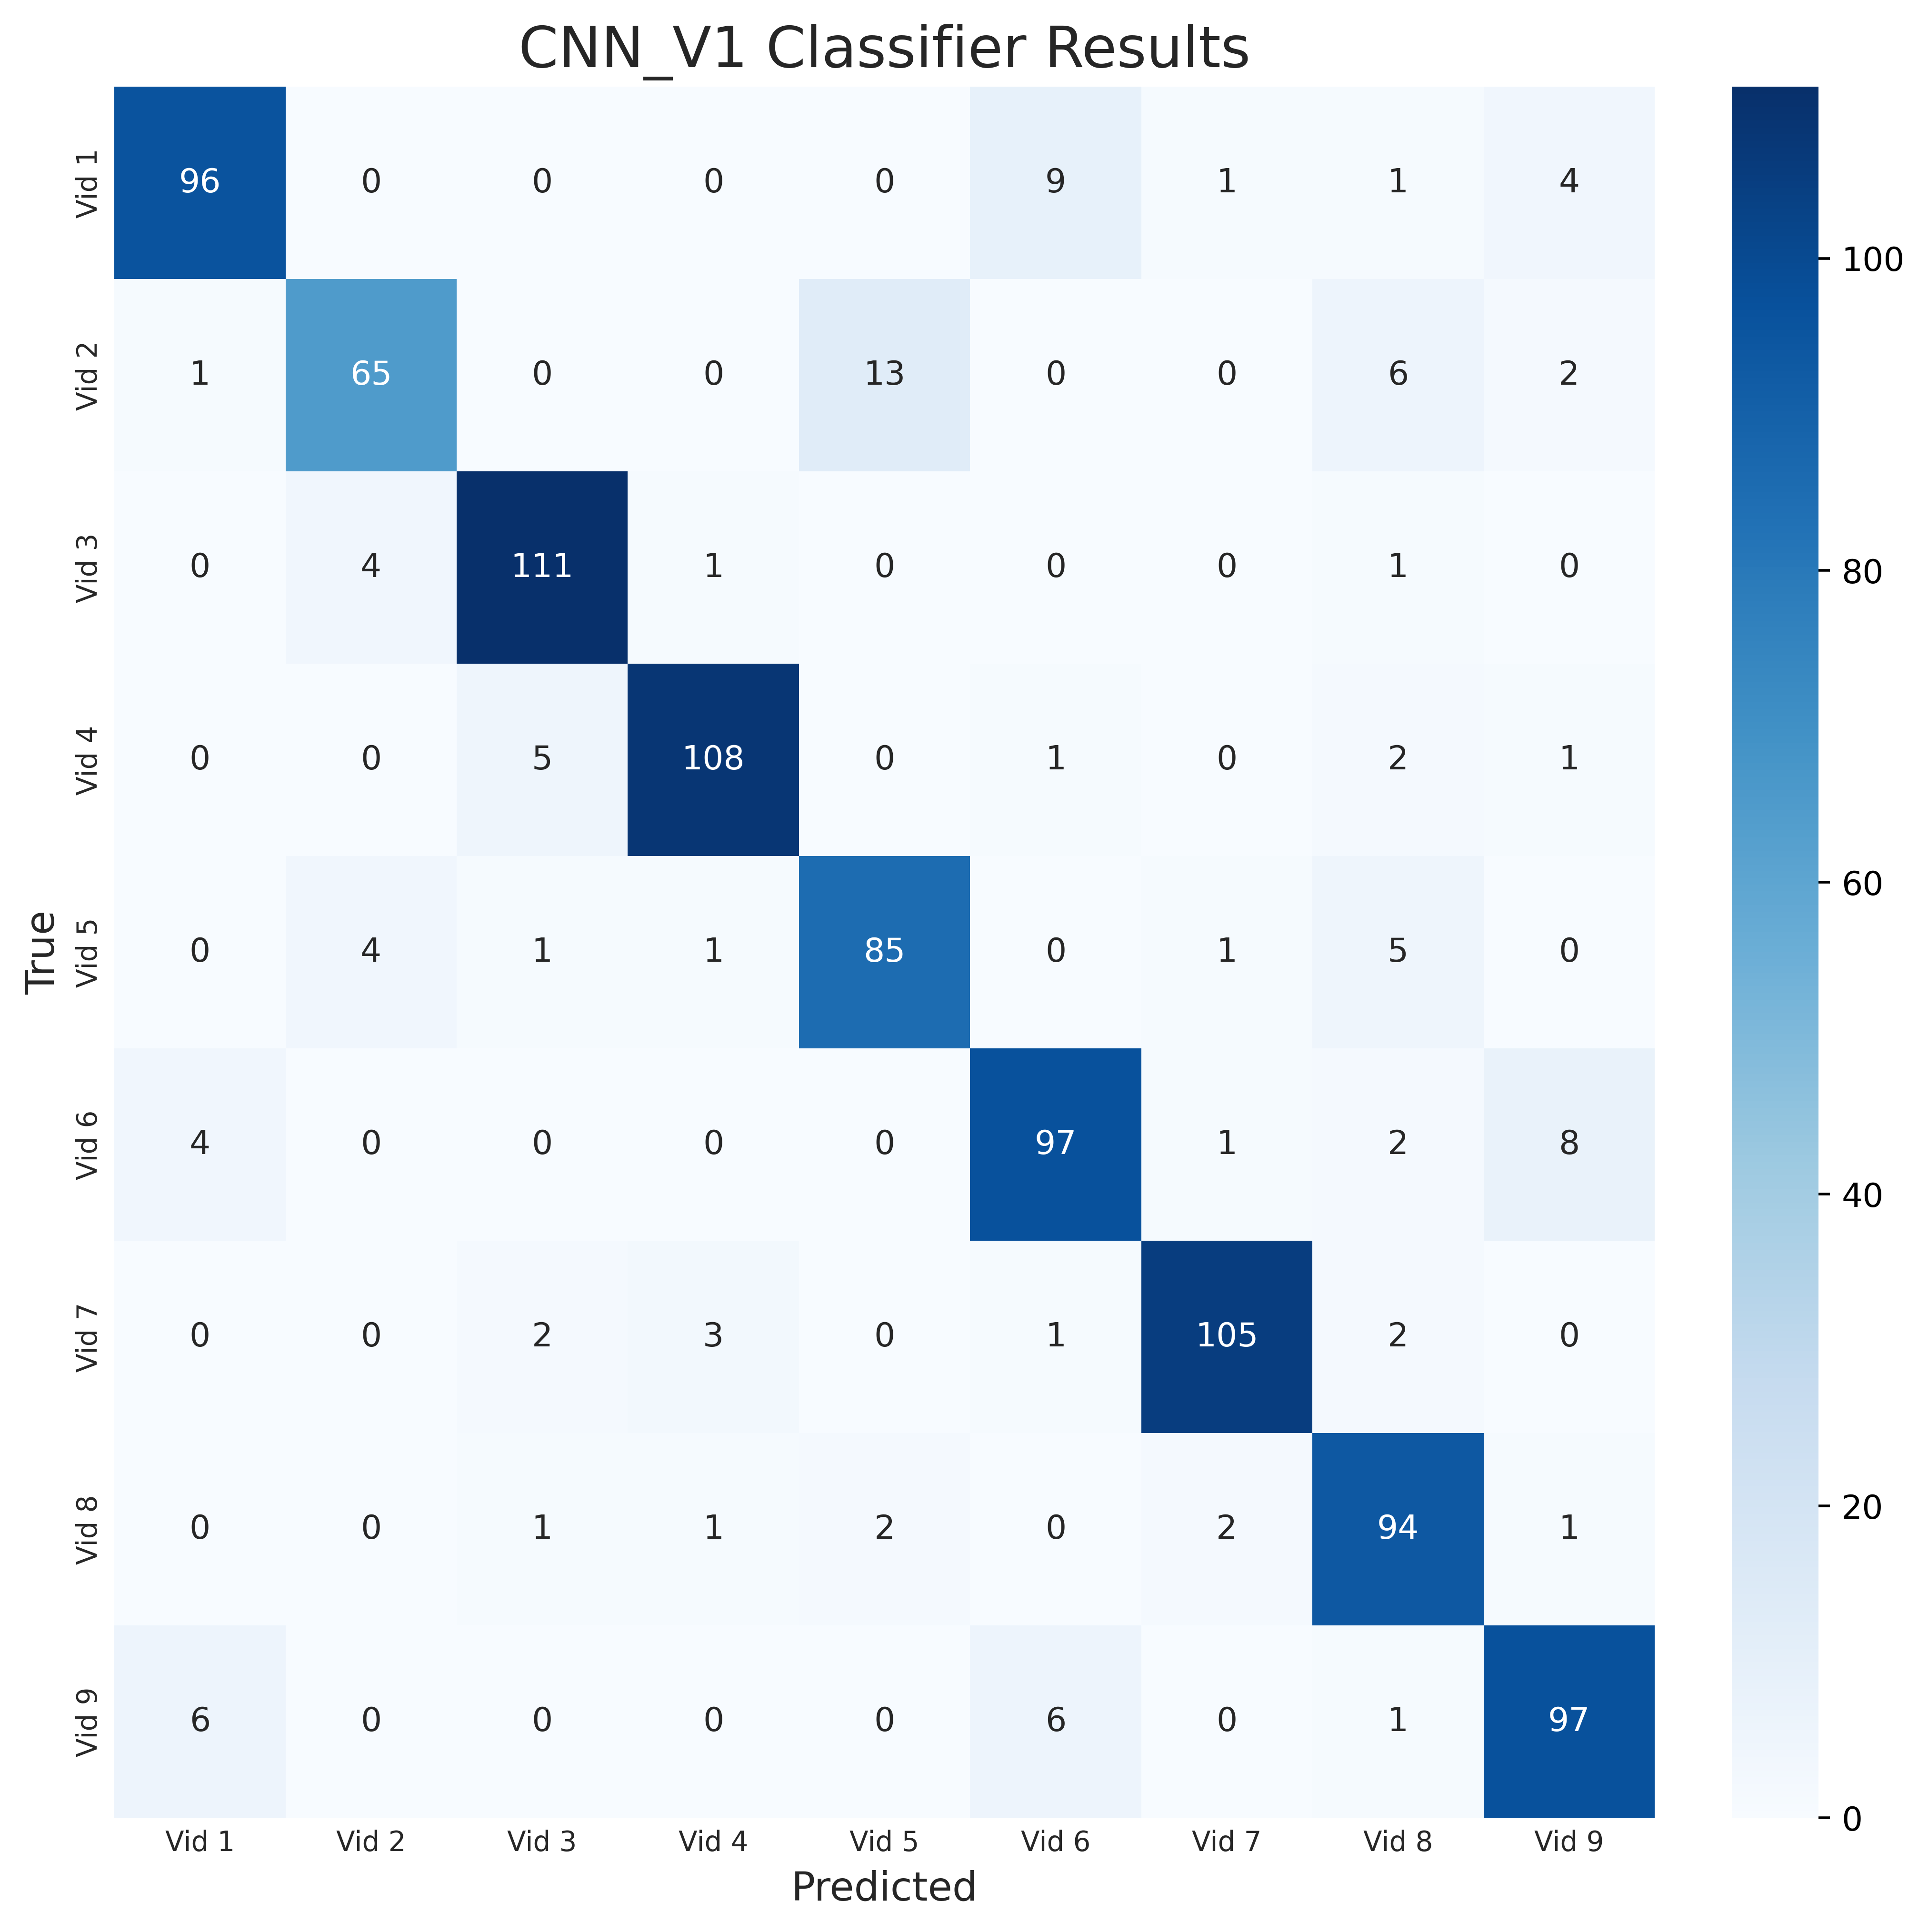

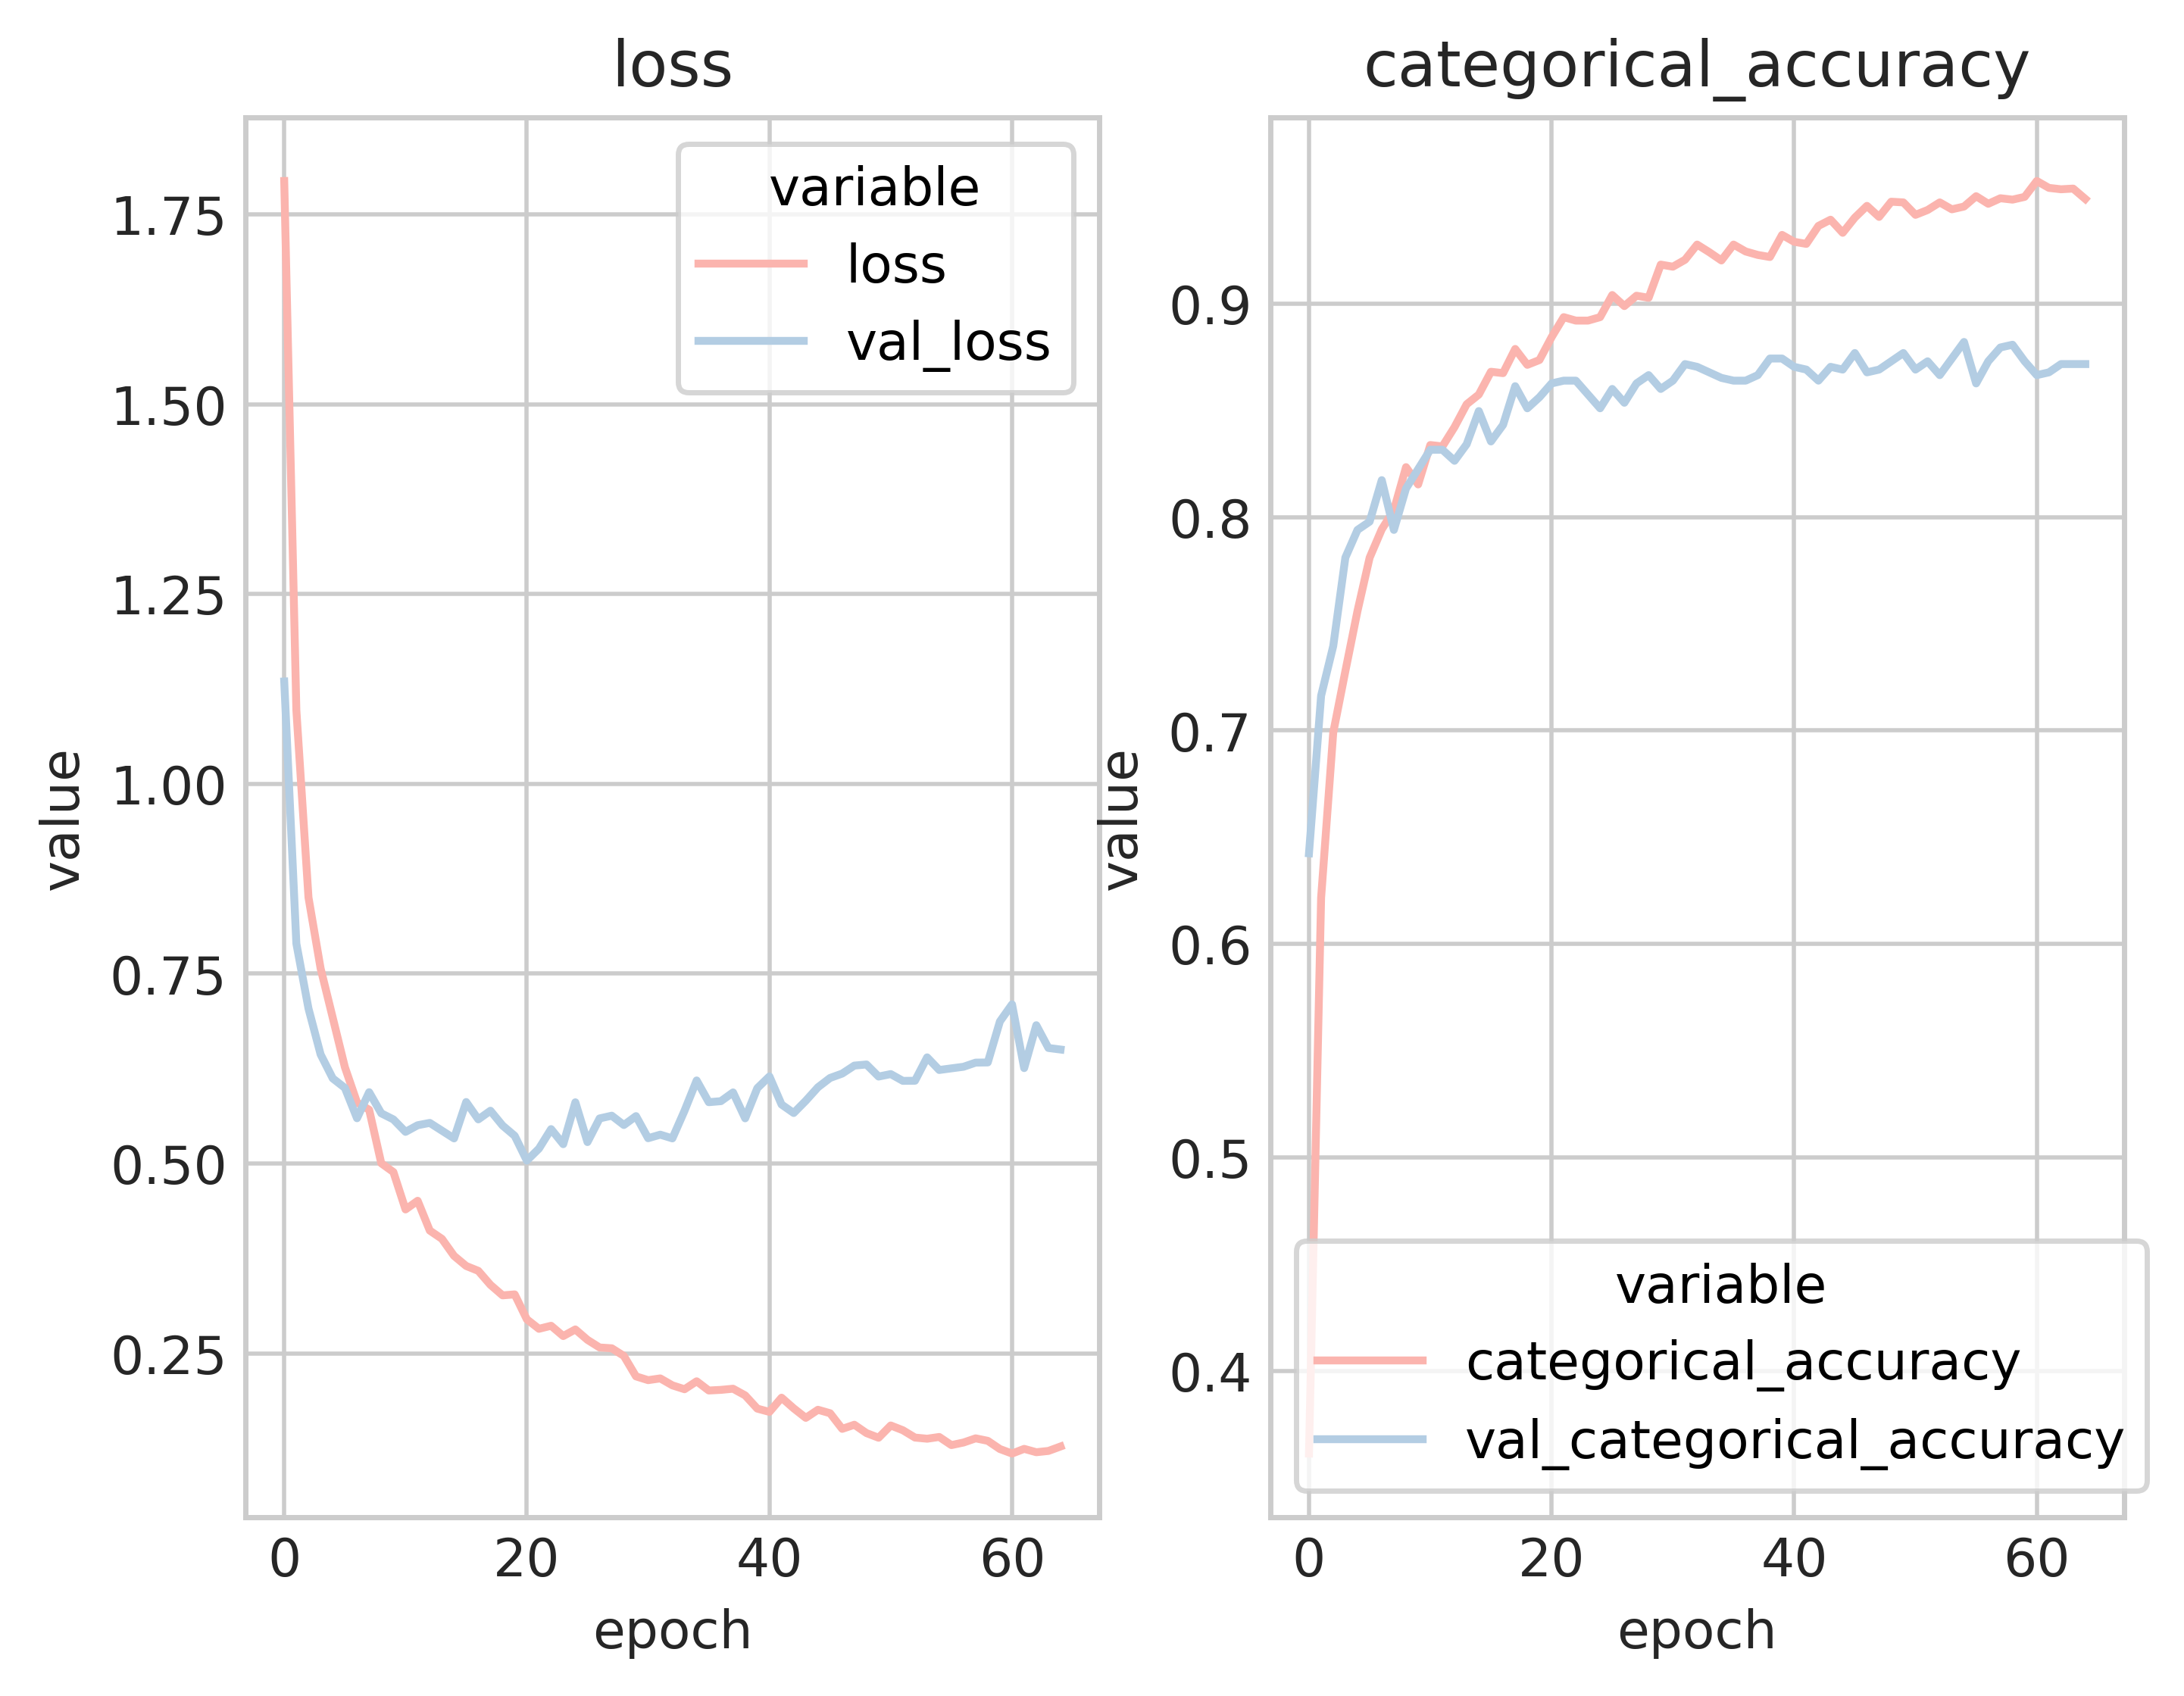

In [18]:
# Simpler CNN. Accuracy ~ 0.88

name = "CNN_V1"

# Hyper-parameters
hparams = {
    "epochs": 100,
    "batch_size": 64,
    "validation_split": 0.2,
    "verbose": True,
    "learning_rate": 0.001,
    "loss": CategoricalCrossentropy(), # FOR CATEGORICAL CLASSIFICATION
    "stopping_monitor":"val_categorical_accuracy", # FOR CATEGORICAL CLASSIFICATION
    # "loss": BinaryCrossentropy(), # FOR BINARY CLASSIFICATION
    # "stopping_monitor":"val_binary_accuracy", # FOR BINARY CLASSIFICATION
}

# Making CNN model Architecture
in1 = Input(shape=X_train.shape[1:])
m1 = Sequential(
    [
        Conv1D(
            8, 5, padding="valid", activation="relu", name="conv_1",
        ),
        MaxPooling1D(
            2, name="maxpool_1",
        ),
        Conv1D(
            16, (3,), padding="valid", activation="relu", name="conv_2",
        ),
        Flatten(
            name="flatten",
        ),
        Dense(
            64, activation="relu", name="dense_1",
        ),
        Dropout(
            0.5, name="dropout_1"
        ),
        Dense( # FOR CATEGORICAL CLASSIFICATION
            len(lb.classes_), activation="softmax", name="output"
        ),
        # Dense( # FOR BINARY CLASSIFICATION
        #     1, activation="sigmoid", name="output"
        # ),
    ],
    name="CNN_V1",
)(in1)

model = Model(
    inputs=[in1],
    outputs=[m1],
    name=name,
)

# Show model architecture
model.summary()

# Saving model
save_model_tf(model, name)
# Save architecture
save_architecture_tf(model, name)

# Training model
train_tf(name, hparams, X_train, y_train)

# Evaluating model
eval_tf(
    name,
    X_test,
    y_test,
    lab_grouping=[0],
    # metrics=["loss", "binary_accuracy"],
)


### CNN Model V2
From Deep Content paper

Model: "CNN_V2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 500, 3)]          0         
                                                                 
 CNN_V2 (Sequential)         (None, 9)                 125865    
                                                                 
Total params: 125865 (491.66 KB)
Trainable params: 125865 (491.66 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
48/49 [============================>.] - ETA: 0s - loss: 1.9738 - categorical_accuracy: 0.2904 - binary_accuracy: 0.8907
Epoch 1: val_categorical_accuracy improved from -inf to 0.58031, saving model to /content/drive/MyDrive/honours/models/wlan/v/CNN_V2/CNN_V2
49/49 [==============================] - 2s 12ms/step - loss: 1.9717 - categorical_accuracy: 0.2912 - binary_accuracy: 0.8907 - val_loss: 1.349

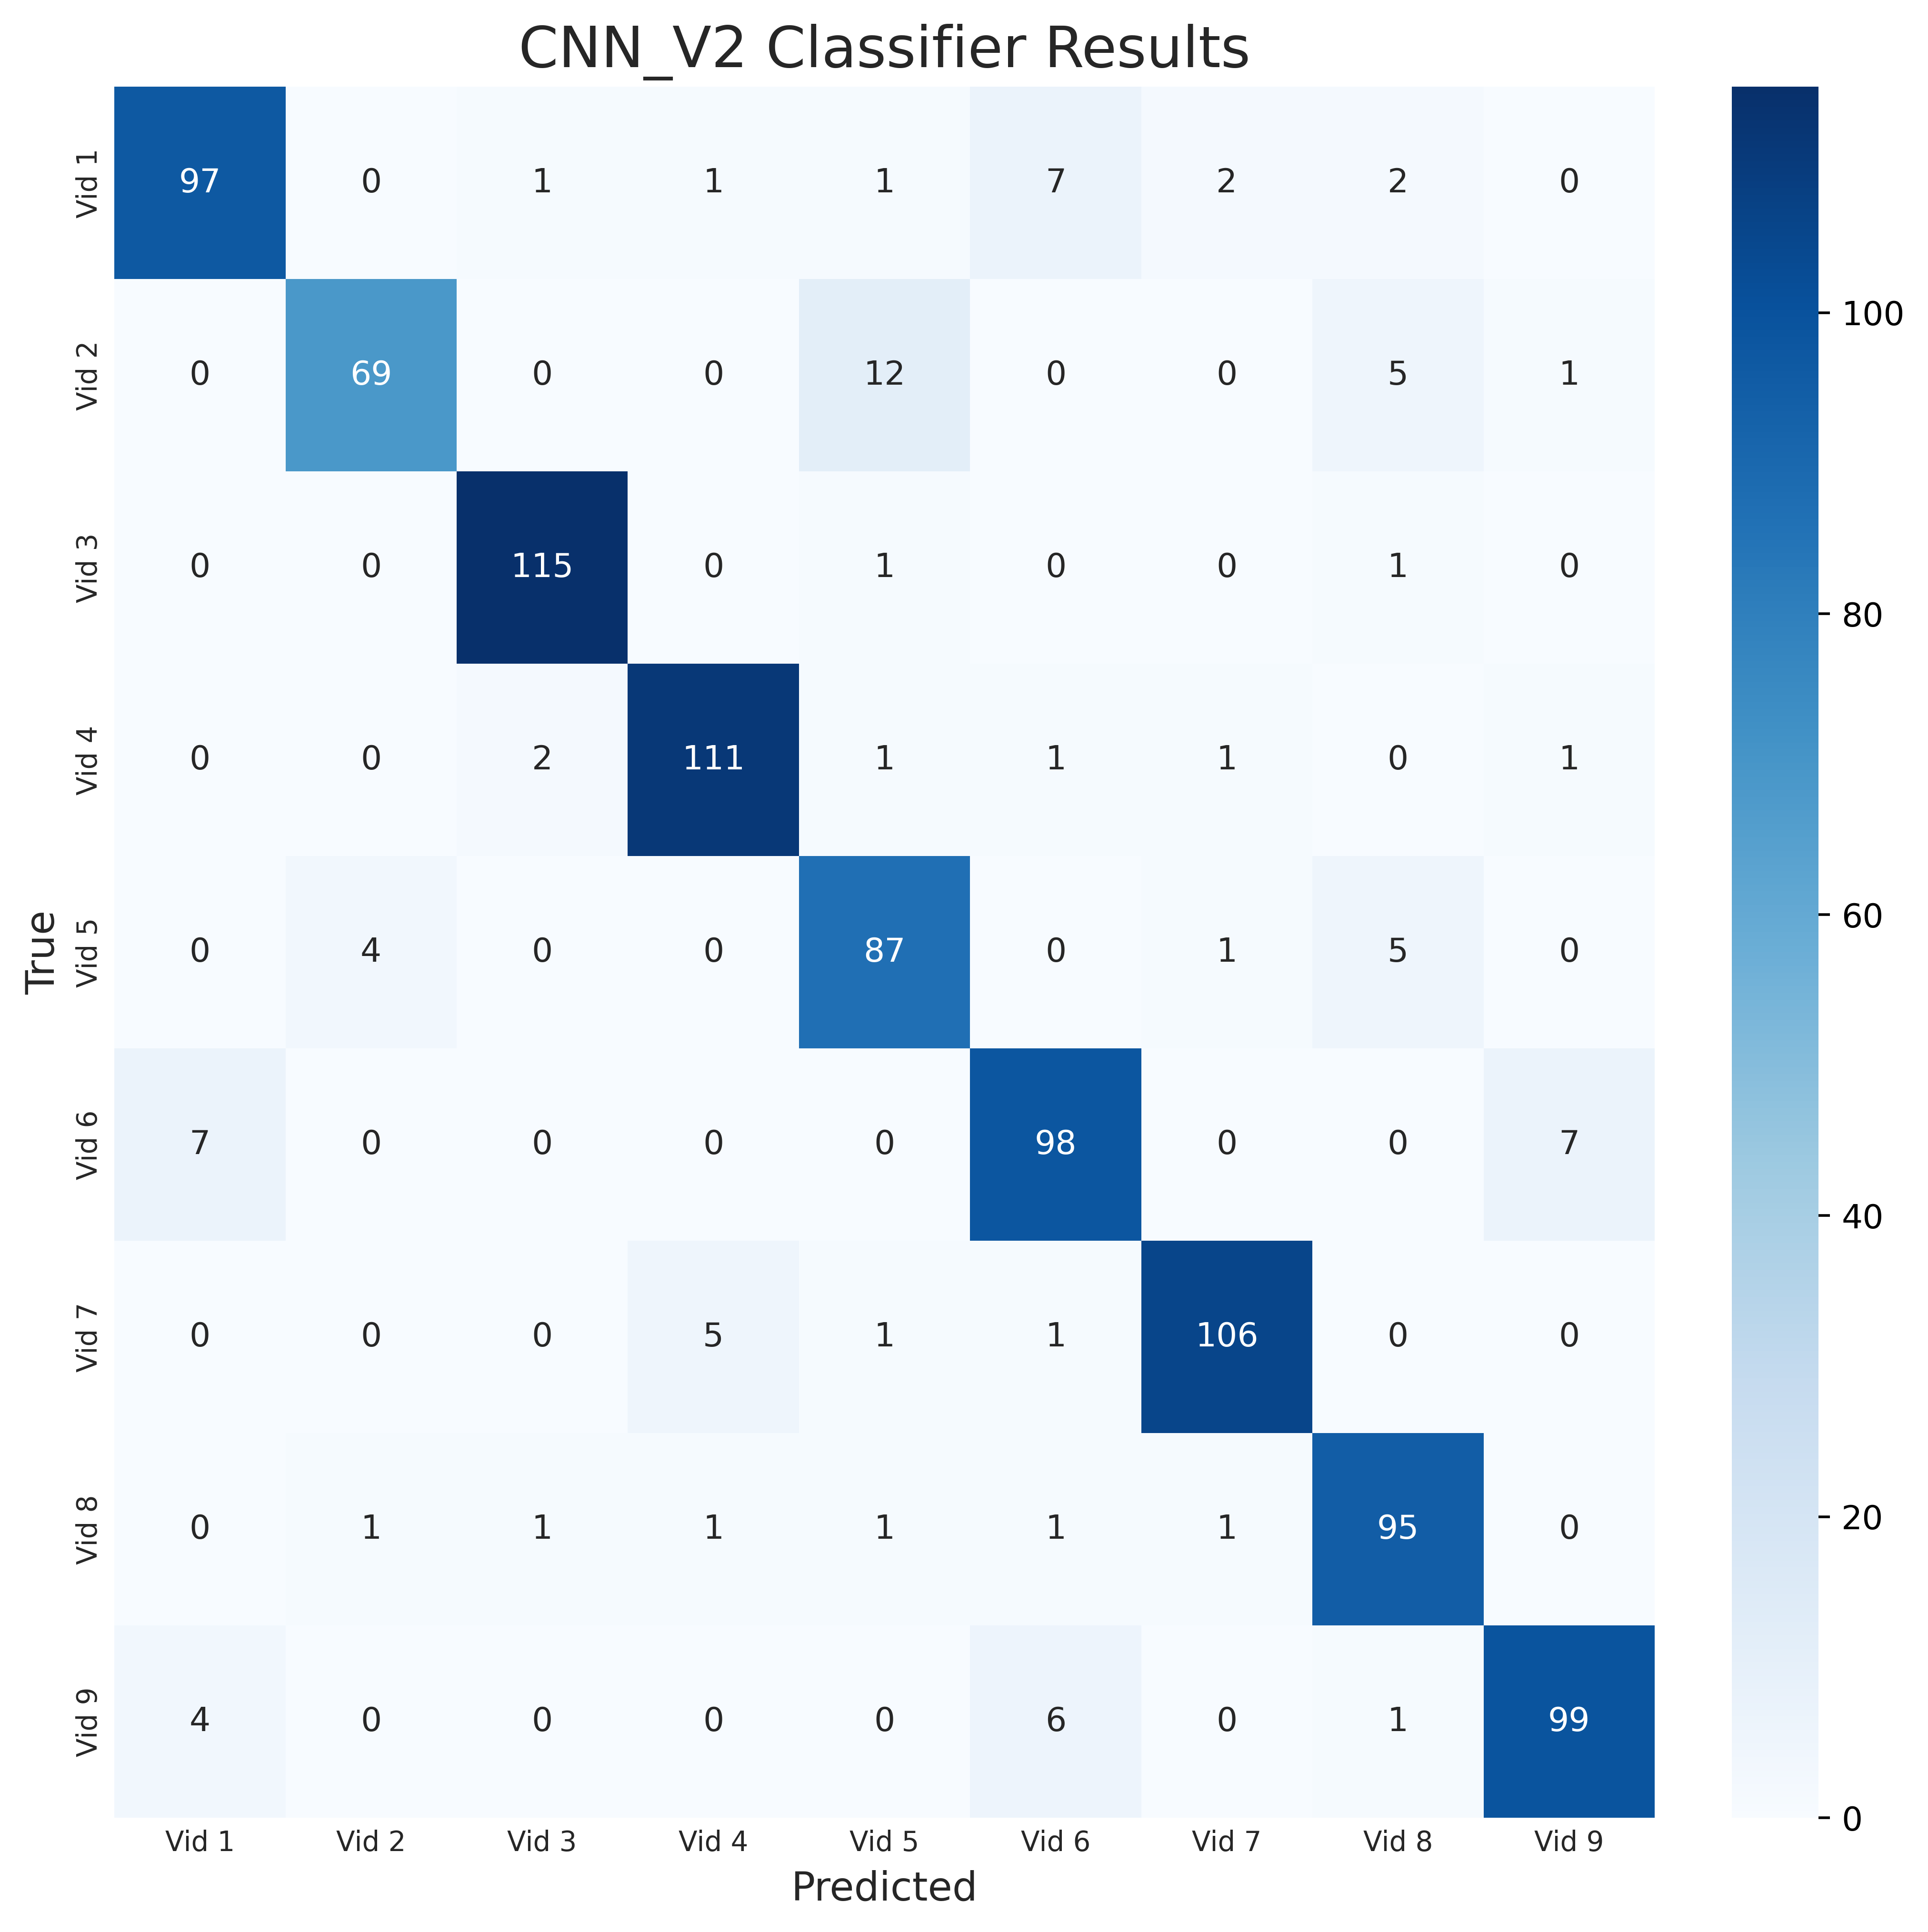

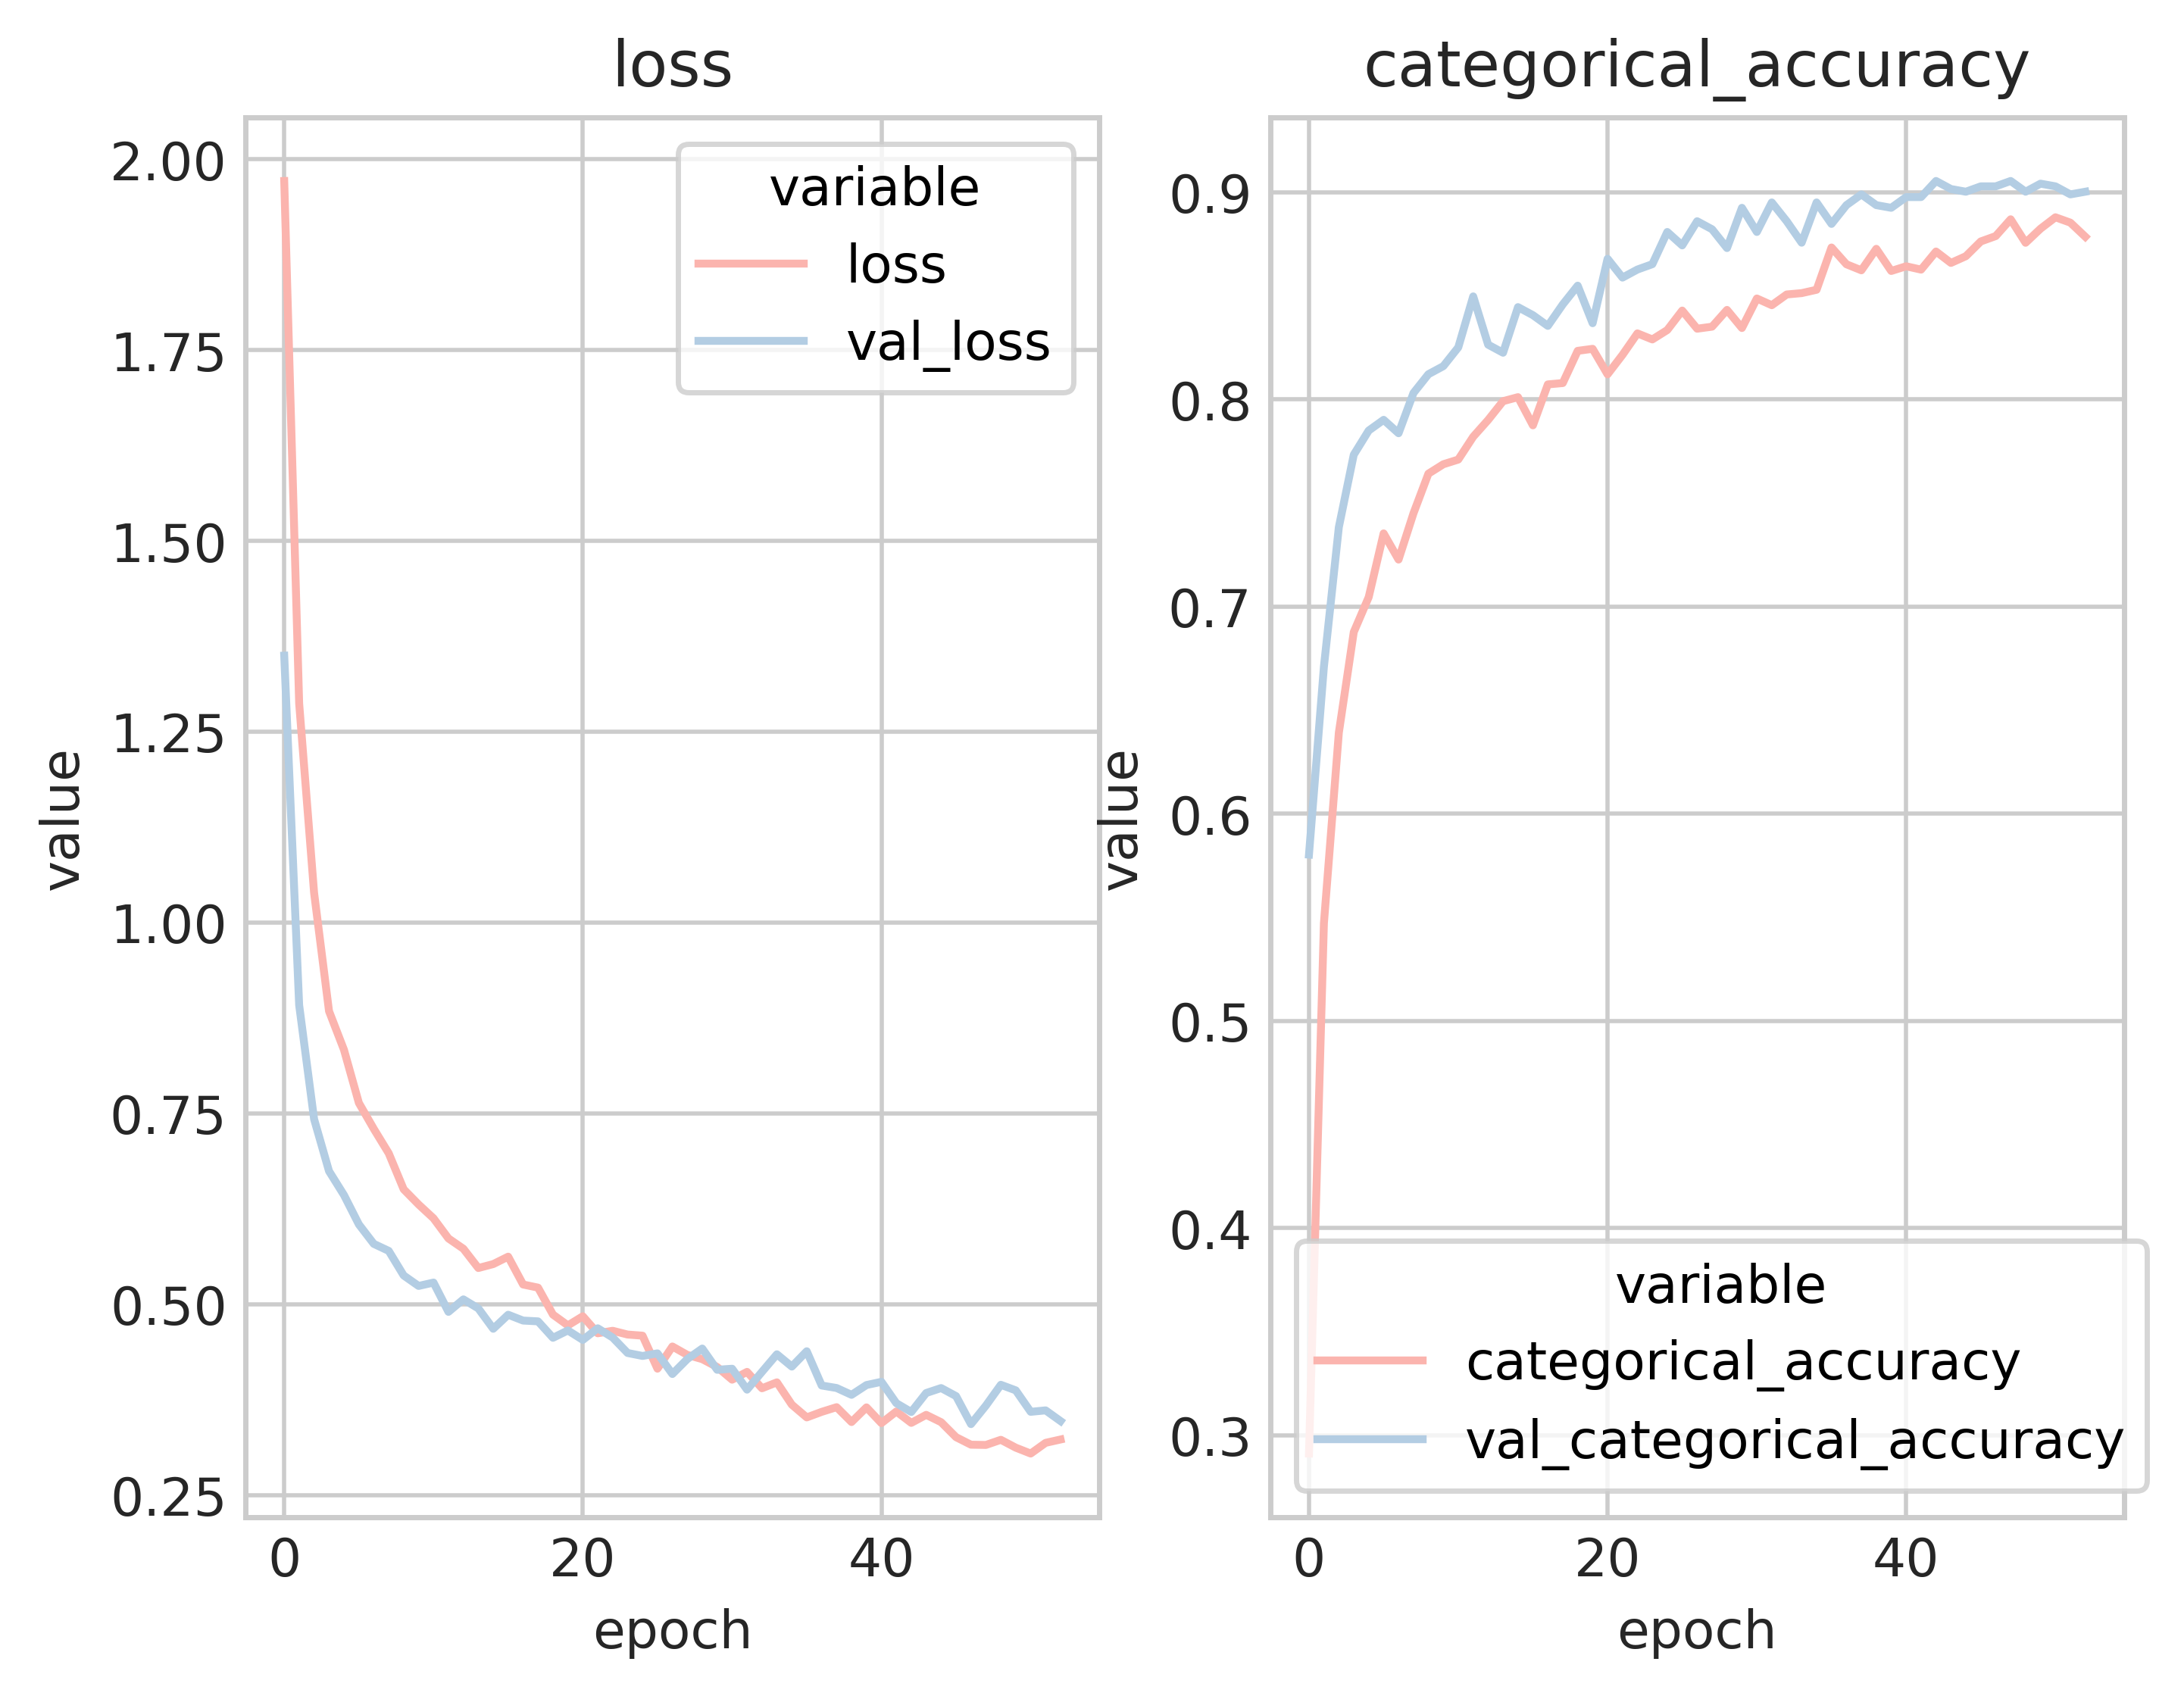

In [19]:
# Deep Content CNN.

name = "CNN_V2"

# Hyper-parameters
hparams = {
    "epochs": 100,
    "batch_size": 64,
    "validation_split": 0.2,
    "verbose": True,
    "learning_rate": 0.001,
    "loss": CategoricalCrossentropy(), # FOR CATEGORICAL CLASSIFICATION
    "stopping_monitor":"val_categorical_accuracy", # FOR CATEGORICAL CLASSIFICATION
    # "loss": BinaryCrossentropy(), # FOR BINARY CLASSIFICATION
    # "stopping_monitor":"val_binary_accuracy", # FOR BINARY CLASSIFICATION
}

# Making CNN model Architecture
in1 = Input(shape=X_train.shape[1:])
m1 = Sequential(
    [
        Conv1D(
            8, 5, padding="valid", activation="relu", name="conv_1",
        ),
        MaxPooling1D(
            2, name="maxpool_1",
        ),
        Conv1D(
            16, (3,), padding="valid", activation="relu", name="conv_2",
        ),
        MaxPooling1D(
            2, name="maxpool_2",
        ),
        Dropout(
            0.5, name="dropout_1"
        ),
        Conv1D(
            16, (3,), padding="valid", activation="relu", name="conv_3",
        ),
        Flatten(
            name="flatten",
        ),
        Dense(
            64, activation="relu", name="dense_1",
        ),
        Dropout(
            0.5, name="dropout_2"
        ),
        Dense( # FOR CATEGORICAL CLASSIFICATION
            len(lb.classes_), activation="softmax", name="output"
        ),
        # Dense( # FOR BINARY CLASSIFICATION
        #     1, activation="sigmoid", name="output"
        # ),
    ],
    name="CNN_V2"
)(in1)

model = Model(
    inputs=[in1],
    outputs=[m1],
    name=name,
)

# Show model architecture
model.summary()

# Saving model
save_model_tf(model, name)
# Save architecture
save_architecture_tf(model, name)

# Training model
train_tf(name, hparams, X_train, y_train)

# Evaluating model
eval_tf(
    name,
    X_test,
    y_test,
    lab_grouping=[0],
    # metrics=["loss", "binary_accuracy"],
)
